## Forbidden Item Classification

## Table of contents
### 1. Abstract
### 2. About dataset
### 3. Prerequisites
### 4. Load data, preprocessing and visualizatiion
### 5. Training CNN
    5.1 Building and compiling model
    5.2 Model summary
    5.3 Data Augmentation
    5.4 Fitting Model
### 6. Evaluating Model
    6.1 Train and validation curves
    6.2 Confusion matrix
    6.3 Visualization of correct predicted classes
    6.4 Visualization of incorrect predicted classes
    6.5 Classification report
### 7. MobileNetV2 Model
    7.1 Trasnfer to RGB color space
    7.2 Transfer model MobileNetV2
    7.3 Data augmentation and model fit
    7.4 MobileNetv2 evaluation
    7.5 MobileNetV2 train and validation curves, confusion matrix and correct/incorrect predicted classes
    7.6 Classification report for MobileNetV2
### 8. ResNetV2 Model
    8.1 Transfer model ResNetV2
    8.2 ResNetV2 model fit
    8.3 ResnetV2 model evalution
    8.4 ResNetV2 train and validation curves, confusion matrix and correct/incorrect predicted classes
    8.5 Classification report for ResNetV2
### 9. Summary

________________________________________________________________________

### 1.Abstract
The goal of the project is to classify forbidden items from X-ray scanner. In this project self-built model was used and two pre-trained models like MobileNet and ResNet for comparison purpose. Data comes from GDXray database.


### 2. About dataset
Dataset consists 19,407 X-ray images. The images are organized in a public database called GDXray that can be used free of charge, but for research and educational purposes only. The database includes five groups of X-ray images: castings, welds, baggage, natural objects and settings.
In this particual project baggage group was used. 
Baggage group contains 77 folders of 8150 images. Each folder contains various images of forbidden objects, baggages and so on.

### 3. Prerequisites

Import modules

In [2]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import math 
import itertools
import random

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler , StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno
import os
from tqdm import tqdm
from tqdm import tqdm_notebook
from pickle import dump, load


Firstly I copied folders that I need for this project which are: B0049, B0051, B0052, B0053, B0054, B0075 and B0076 to one "Images" folder.
Next I rename images files to correspond what particual image contain with self written script called rename_file.py

All the renamed files are copied to one folder called Images

### 4. Load data, preprocessing and visualizatiion

#### 4.1 Load data
Below are two functions that helps to read images and labels to arrays. First one, based on list of images path read them and from the file name, assigns a label to y array. Files names are extracted thankfuly to previous script. The list of images or more likely list of paths is generated with second function.

In [3]:
def read_and_process_image(list_of_images):

    """"
    Returns two arrays:
    X is an array of resized images
    y is an array of labels
    """

    X = [] #images
    y = [] #labels
    random.shuffle(list_of_images)
    for i in tqdm(range(len(list_of_images))):
        img = image.load_img(list_of_images[i])
        img = image.img_to_array(img)
        X.append(img)
        if 'Gun' in (list_of_images)[i]:
            y.append(0) # 0 Gun
        elif 'Razor' in (list_of_images)[i]:
            y.append(1) # 1 Razor
        elif 'Key' in (list_of_images)[i]:
            y.append(2) # 2 Key
        elif 'Knife' in (list_of_images)[i]:
            y.append(3) # 3 Knife
        elif '6p_Shuriken' in (list_of_images)[i]:
            y.append(4) # 4 six_point_Shurkien
        elif '7p_Shuriken' in (list_of_images)[i]:
            y.append(5) # 5 seven_point_Shurkien
        elif '8p_Shuriken' in (list_of_images)[i]:
            y.append(6) # 6 eight_point_Shurkien
    X = np.array(X)
    y = np.array(y)
    return X, y
def getFiles(path):
    path_list=[]
    for file in os.listdir(path):
        if file.endswith(".png"):
            path_list.append(os.path.join(path, file))
    return path_list

Here data path is path that leads to folder which contains images belonging to various classes that are named with corresponding class and number, ie. 'Gun_1' or 'Key_99'. 
With functions presented above, the output are two arrays X, which contains 2147 images of various sizes and y with labels.

In [4]:
data_path = '/Users/mateuszkucharuk/Desktop/0_forbidden_items_detector/Images_1'

path_list = getFiles(data_path)
X, y = read_and_process_image(path_list)
X.shape, y.shape

100%|██████████| 2147/2147 [00:57<00:00, 37.14it/s]


((2147,), (2147,))

#### 4.2 Image data reshape
Currently images are in various shapes. For CNN it is required for all images to have the same shape. height and width is set to 224 due to default ResNet50 model image shape. X_resized is the output for function

In [5]:
def img_arr_reshape(arr_input_images, dim):

    width, height = dim
    resizied_list_of_images = []
    for i in tqdm(range(len(arr_input_images))):
        resizied_list_of_images.append(cv2.resize(arr_input_images[i], dim, interpolation = cv2.INTER_AREA))
        
    resizied_list_of_images = np.asarray(resizied_list_of_images)
    return resizied_list_of_images

In [6]:
h, w = 224, 224
X_resized = img_arr_reshape(X, (h, w))

100%|██████████| 2147/2147 [00:35<00:00, 61.03it/s]


In [7]:
X_resized.shape

(2147, 224, 224, 3)

In [8]:
X[1]

array([[[221., 221., 221.],
        [224., 224., 224.],
        [223., 223., 223.],
        ...,
        [226., 226., 226.],
        [231., 231., 231.],
        [228., 228., 228.]],

       [[224., 224., 224.],
        [220., 220., 220.],
        [220., 220., 220.],
        ...,
        [224., 224., 224.],
        [228., 228., 228.],
        [227., 227., 227.]],

       [[226., 226., 226.],
        [221., 221., 221.],
        [224., 224., 224.],
        ...,
        [227., 227., 227.],
        [226., 226., 226.],
        [226., 226., 226.]],

       ...,

       [[222., 222., 222.],
        [222., 222., 222.],
        [224., 224., 224.],
        ...,
        [225., 225., 225.],
        [226., 226., 226.],
        [227., 227., 227.]],

       [[222., 222., 222.],
        [222., 222., 222.],
        [227., 227., 227.],
        ...,
        [221., 221., 221.],
        [225., 225., 225.],
        [225., 225., 225.]],

       [[222., 222., 222.],
        [227., 227., 227.],
        [223., 2

#### 4.3 Transfer rgb images to grayscale
For quicker performance color space transfer from rgb to grayscale is performed. Instead of 3 color channels, model will work on 1 channel.

In [8]:
def grayscale_img_transfer(input_list):
    transfered_img = []
    for i in tqdm(range(len(input_list))):
        transfered_img.append(cv2.cvtColor(input_list[i], cv2.COLOR_BGR2GRAY))
        
    transfered_img = np.asarray(transfered_img)
    return transfered_img

In [9]:
X_gray = grayscale_img_transfer(X_resized)
X_gray.shape

100%|██████████| 2147/2147 [00:00<00:00, 3856.45it/s]


(2147, 224, 224)

In [11]:
X_gray[1]

array([[223.43288, 225.13823, 224.85994, ..., 227.575  , 227.19835,
        226.93571],
       [222.86769, 225.42747, 224.74217, ..., 226.75882, 226.0567 ,
        227.41617],
       [223.38904, 223.77922, 225.00443, ..., 225.7686 , 226.64691,
        225.8883 ],
       ...,
       [223.09819, 221.85294, 221.62196, ..., 223.99554, 225.84933,
        224.72417],
       [221.60457, 222.20784, 223.15672, ..., 224.46092, 226.17633,
        224.82014],
       [222.37221, 223.02222, 222.60059, ..., 226.11327, 223.59813,
        225.28922]], dtype=float32)

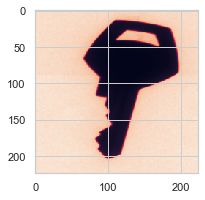

In [9]:
plt.figure(figsize=(3,3))
plt.imshow(X_gray[4])
plt.show()

"Artificialy" one channel is added for modeling purpose

In [10]:
X_1 =X_gray.reshape((-1, h, w, 1))

In [12]:
X_1.shape

(2147, 224, 224, 1)

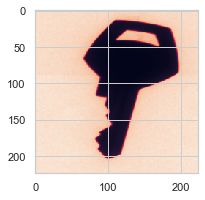

In [13]:
plt.figure(figsize=(3,3))
plt.imshow(X_gray[4])
plt.show()

#### 4.4 Data normalization
Images are often stored as integer numbers (0-255). They need to be converted to float numbers (0-1) in order for models to work much faster. 

In [11]:
X_norm = X_1.astype("float32")/255

In [15]:
X_norm[1]

array([[[0.9041191 ],
        [0.9041191 ],
        [0.9041191 ],
        ...,
        [0.90588236],
        [0.90588236],
        [0.90588236]],

       [[0.8970661 ],
        [0.8970661 ],
        [0.8970661 ],
        ...,
        [0.90588236],
        [0.90588236],
        [0.90588236]],

       [[0.89411765],
        [0.89411765],
        [0.89411765],
        ...,
        [0.90588236],
        [0.90588236],
        [0.90588236]],

       ...,

       [[0.90588236],
        [0.90588236],
        [0.90588236],
        ...,
        [0.9129355 ],
        [0.90940887],
        [0.90588236]],

       [[0.90588236],
        [0.90588236],
        [0.90588236],
        ...,
        [0.9129355 ],
        [0.9094088 ],
        [0.90588236]],

       [[0.90588236],
        [0.90588236],
        [0.90588236],
        ...,
        [0.9129355 ],
        [0.90940887],
        [0.90588236]]], dtype=float32)

In [12]:
y

array([2, 2, 1, ..., 3, 0, 1])

One-Hot encoding

In [13]:
y_cat = to_categorical(y, num_classes=7)

In [14]:
y_cat.shape

(2147, 7)

In [15]:
X=X_norm.copy()

In [16]:
X.shape

(2147, 224, 224, 1)

#### 4.5 Data visualization

In [17]:
classes = {0 : 'Gun', 
           1 : 'Razor', 
           2 : 'Key', 
           3 : 'Knife', 
           4 : '6p_Shuriken', 
           5 : '7p_Shuriken',
           6 : '8p_Shuriken'}


Plotting random images

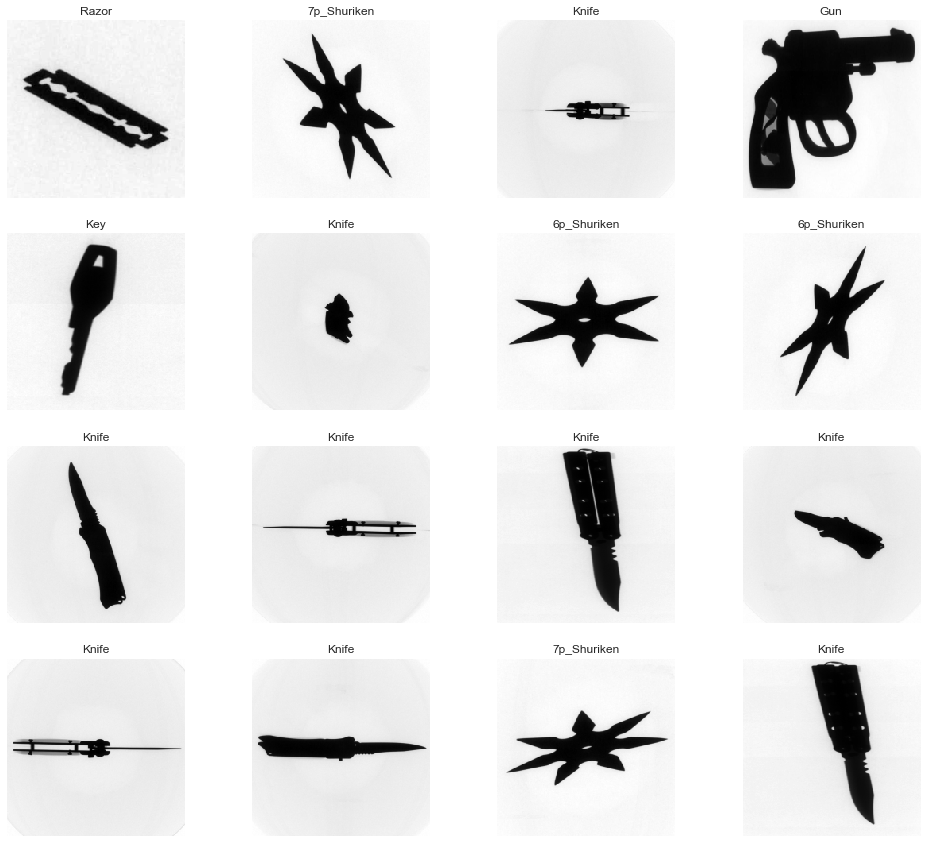

In [39]:
fig, axes = plt.subplots(4, 4, figsize = (15,15))
for row in axes:
    for axe in row:
        index = np.random.randint(1000)
        img = X_gray[index]
        item = y[index]
        axe.imshow(img, cmap='gray')
        axe.set_title(classes[item])
        axe.set_axis_off()

#### 4.6 Train and test data split
Split the training data into train and testing set. Train set is used for training the model and testing set is used for evaluating model's performance on the dataset.

In [18]:
seed = 66
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_cat, test_size=0.21, random_state=seed)

In [19]:
X_train.shape

(1696, 224, 224, 1)

In [23]:
y_train.shape

(1696, 7)

In [20]:
y_train_code=y_train.argmax(1)

In [21]:
y_train_code.shape

(1696,)

In [22]:
y_test.shape

(451, 7)

In [23]:
y_train.shape

(1696, 7)

In [24]:
X_train.shape

(1696, 224, 224, 1)

In [29]:
X_test.shape

(451, 224, 224, 1)

#### 4.7 Train data count
Before modeling lets see if the data is balanced

In [41]:
(unique, counts) = np.unique(y_train_code, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 150]
 [  1 300]
 [  2 163]
 [  3 731]
 [  4 119]
 [  5 123]
 [  6 110]]


In [42]:
df = pd.DataFrame(frequencies, columns=["unique", "counts"])

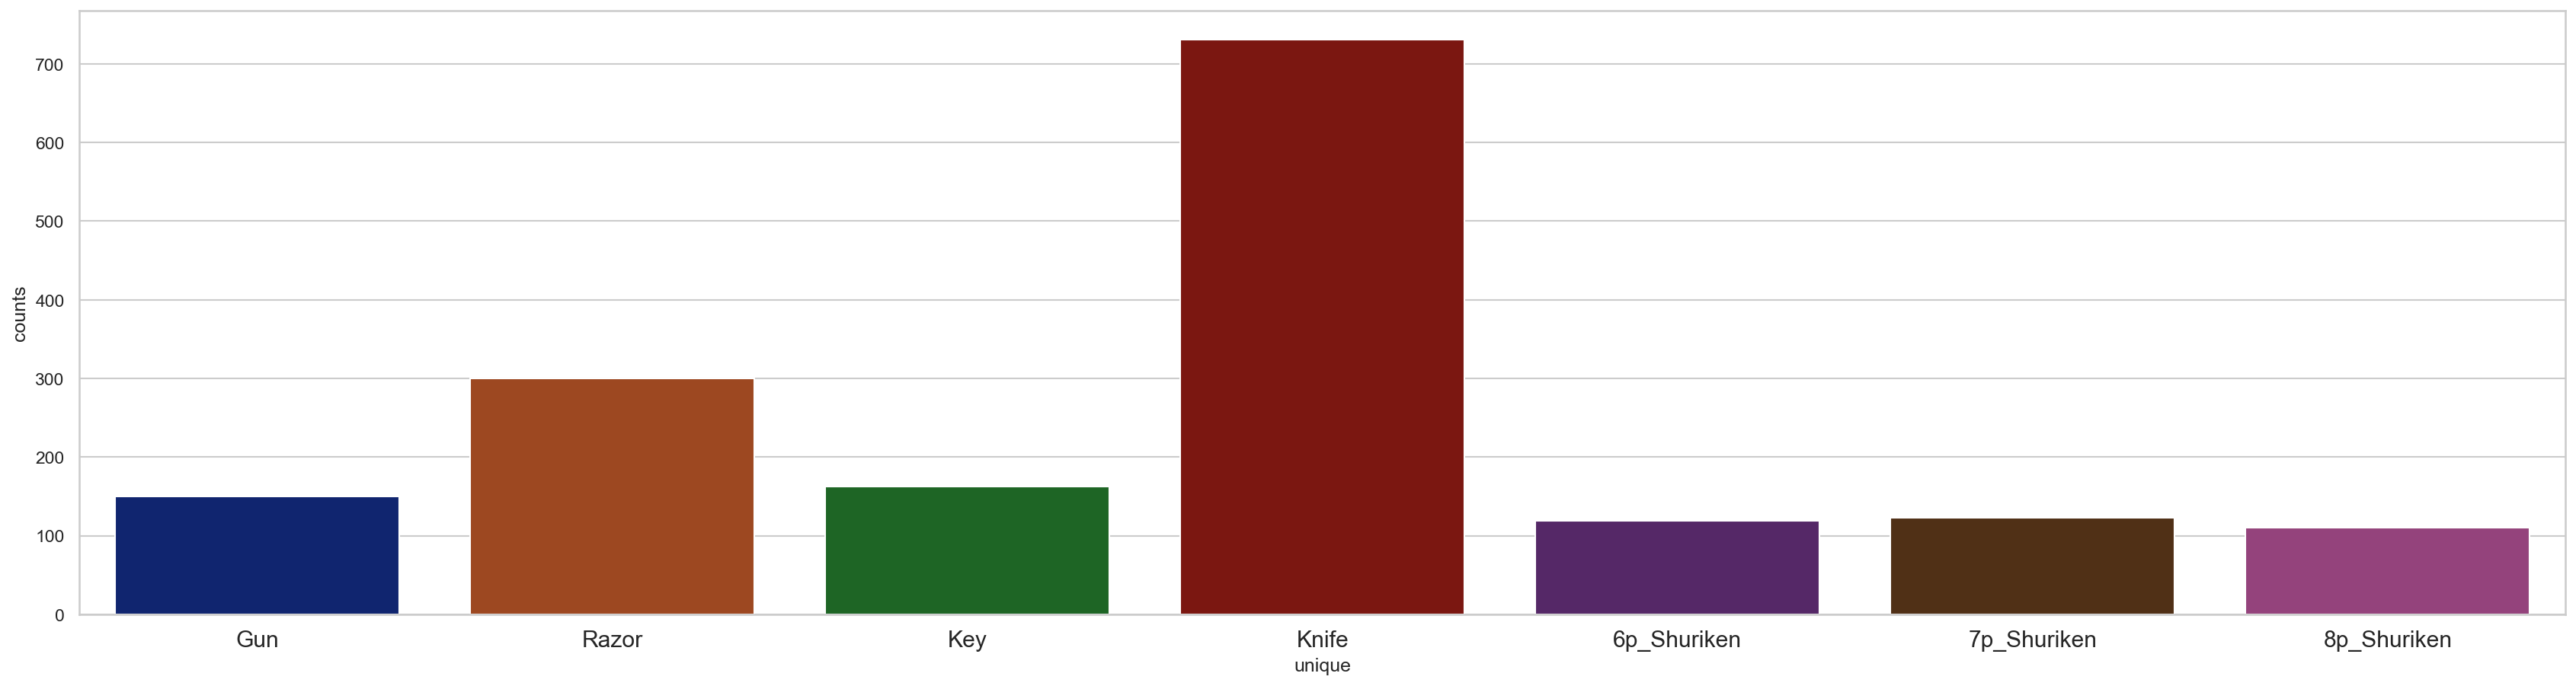

In [43]:
sns.barplot(x=df['unique'].map(classes), y="counts", data=df)

##### Data is not balanced, image augmentation is required

### 5. Training CNN

#### 5.1 Building and compiling model
Building own model. First layer is input layer where the input data shape is defined. With resize function the height as h and width as w where defined for 224 and 224 px. So h and w stands for 224. 
Batch normalization for accelerating learning process and normalize the input(0-1)
Also the strides are from range 1-3 to reduce train-able params and avoid overfitting.

In [37]:
my_model = Sequential()

my_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', 
                 input_shape=(h, w, 1)))
my_model.add(BatchNormalization())

my_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=2, padding='same', data_format='channels_last'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.35))

my_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=3, padding='same', data_format='channels_last'))
my_model.add(MaxPooling2D(pool_size=(2, 2)))
my_model.add(Dropout(0.25))
    
    
my_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=2, padding='same', 
                 data_format='channels_last'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.25))

my_model.add(Flatten())
my_model.add(Dense(512, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.35))
my_model.add(Dense(256, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.25))
my_model.add(Dense(128, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(Dropout(0.25))
my_model.add(Dense(7, activation='softmax'))

Compile the model. Optimizer set to 'Adam' with default parameters. Loss set to 'categorical_crossentropy' for multi-class classification and metric to evalute set to 'accuaracy'.

In [38]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

In [39]:
my_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#### 5.2 Model summary

In [40]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 19, 64)        0

Callbacks
reduce_lr for faster learning to reduce learning rate
early_stopping with patience 20 to stop learning if tthe val_loss doesnt drop anymore
and get_checkpoint for model check points savings.

In [41]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [42]:
early_stopping = EarlyStopping(patience=20, monitor="val_loss", verbose=1, restore_best_weights=True)

In [43]:
def get_checkpoint(model_name):
    checkpoint_path = '/Users/mateuszkucharuk/Desktop/0_forbidden_items_detector/Projekt_v3_checkpoints/' \
    + '_7classes_' + model_name + '-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
    return ModelCheckpoint(checkpoint_path, 
                           monitor='val_accuracy', 
                           mode='max', 
                           verbose=0, 
                           save_best_only=True)

#### 5.3 Data Augmentation

In [44]:
datagen = ImageDataGenerator(rotation_range = 78,  # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.5, # Randomly zoom image 
                             shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
                             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
                             vertical_flip=True)  # randomly flip images

In [45]:
datagen.fit(X_train)

In [46]:
batch_size = 32
epochs = 100

In [48]:
my_model_checkpoint = get_checkpoint('my_model')

#### 5.4 Fitting Model

In [49]:
my_model_history = my_model.fit(datagen.flow(X_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (X_test, y_test), verbose=1, 
                              steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks = [reduce_lr, early_stopping, my_model_checkpoint])



Epoch 1/100
53/53 [==============================] - 85s 2s/step - loss: 1.5605 - accuracy: 0.4847 - val_loss: 1.7676 - val_accuracy: 0.4279
Epoch 2/100
53/53 [==============================] - 87s 2s/step - loss: 0.9350 - accuracy: 0.6745 - val_loss: 2.2965 - val_accuracy: 0.4279
Epoch 3/100
53/53 [==============================] - 85s 2s/step - loss: 0.7504 - accuracy: 0.7305 - val_loss: 2.5052 - val_accuracy: 0.4279
Epoch 4/100
53/53 [==============================] - 83s 2s/step - loss: 0.6950 - accuracy: 0.7376 - val_loss: 2.6102 - val_accuracy: 0.1907
Epoch 5/100
53/53 [==============================] - 86s 2s/step - loss: 0.5814 - accuracy: 0.7730 - val_loss: 2.5507 - val_accuracy: 0.1752
Epoch 6/100
53/53 [==============================] - 84s 2s/step - loss: 0.5617 - accuracy: 0.7854 - val_loss: 5.1563 - val_accuracy: 0.1752
Epoch 7/100
53/53 [==============================] - 81s 2s/step - loss: 0.5442 - accuracy: 0.7754 - val_loss: 3.0530 - val_accuracy: 0.1752
Epoch 8/100
5

In [50]:
dump(my_model_history.history, 
     open('/Users/mateuszkucharuk/Desktop/0_forbidden_items_detector/Projekt_v3__data/my_model_history.pkl', 'wb'))

### 6. Evaluating Model

In [32]:
score = my_model.evaluate(X_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

15/15 [==============================] - 4s 236ms/step - loss: 0.2230 - accuracy: 0.9157
Loss: 0.2230
Accuracy: 0.9157


#### 6.1 Train and validation curves

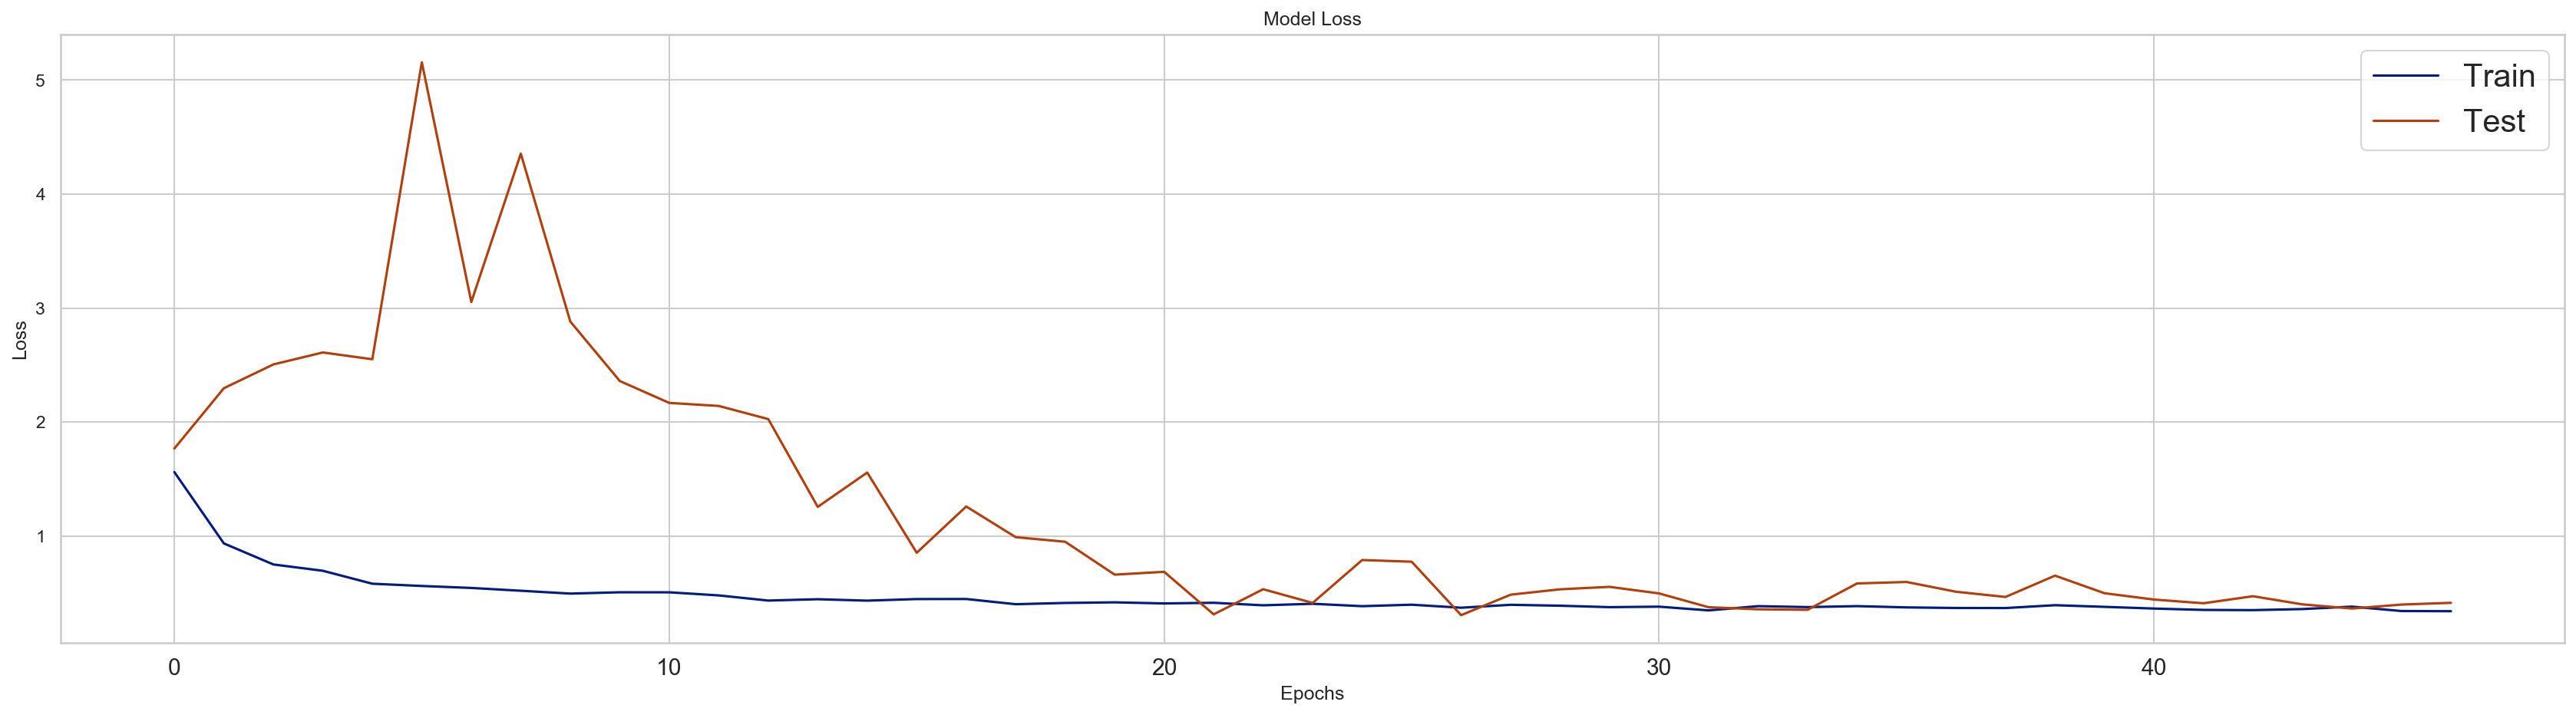

In [52]:
plt.plot(my_model_history.history['loss'])
plt.plot(my_model_history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

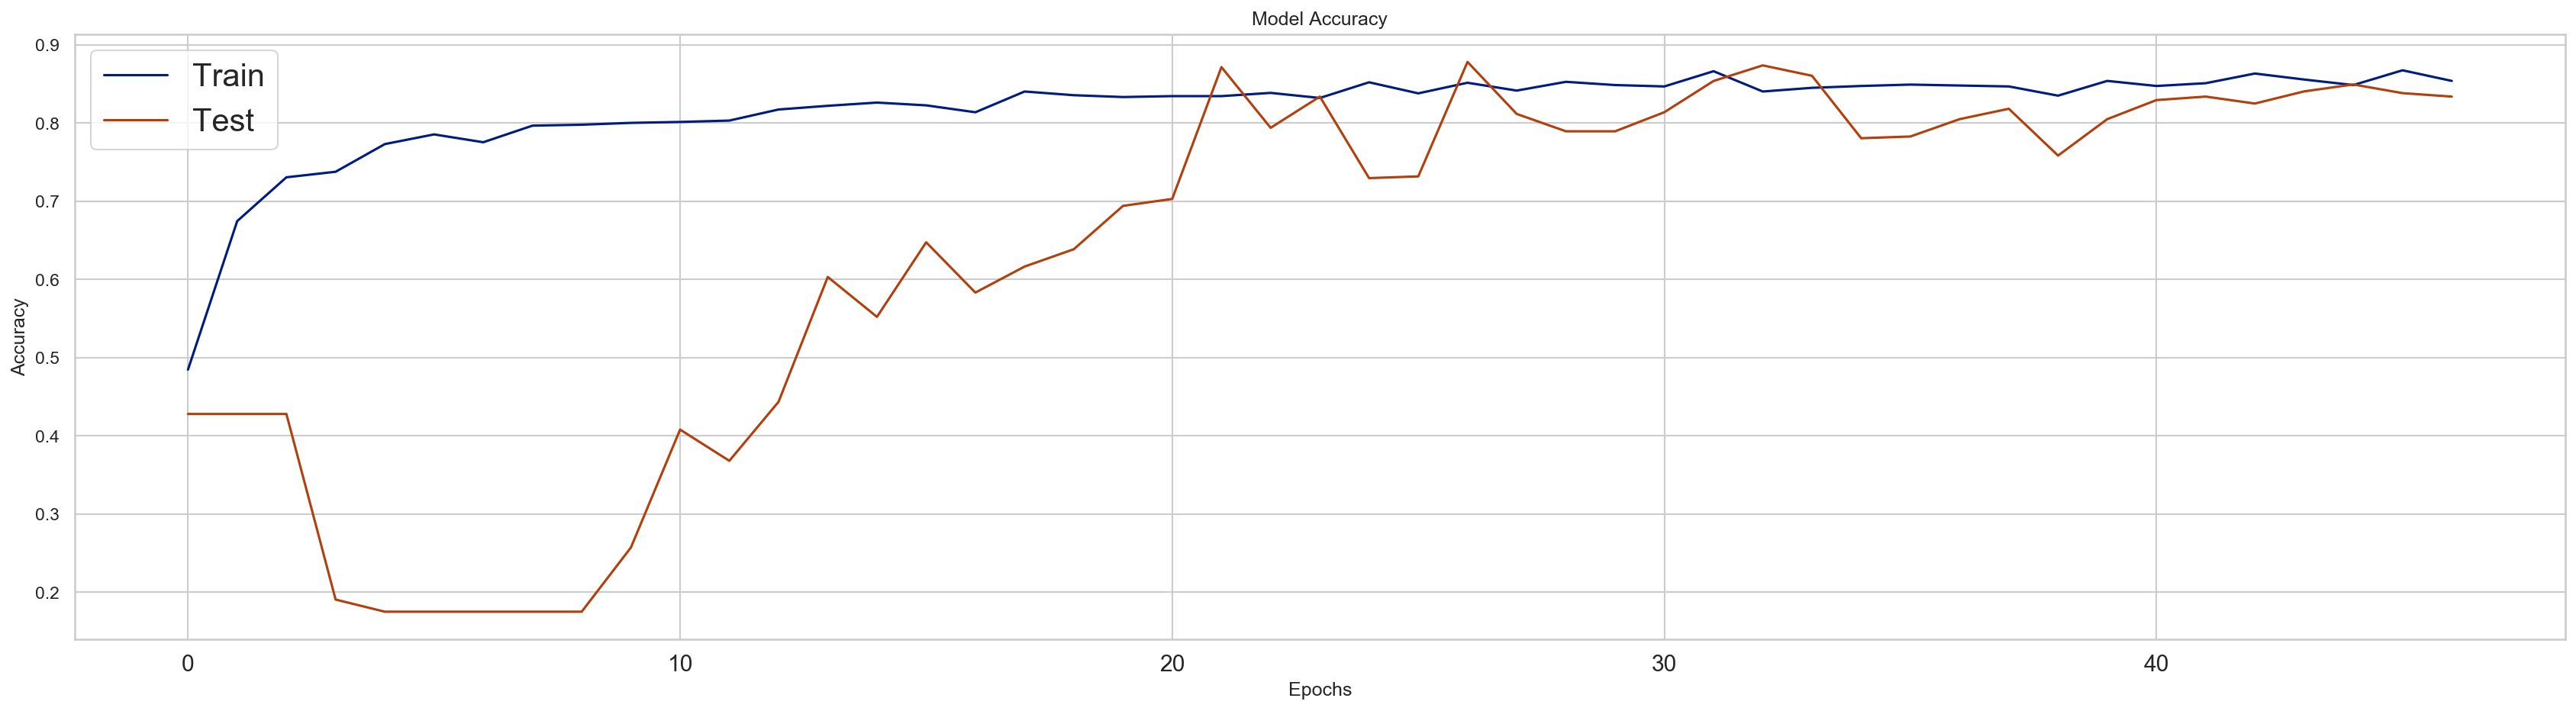

In [53]:
plt.plot(my_model_history.history['accuracy'])
plt.plot(my_model_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

#### 6.2 Confusion matrix
Below function generates a confusion matrix for model that was trained. The input requires model, train array and labels. 

In [33]:
def plot_confusion_matrix(model_name, cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    
#     plt.figure(figsize=(5,5))
    title='Confusion matrix ' + str(model_name)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    plt.ylabel('True label')

In [34]:
def show_confusion_matrix(trained_model, test_input, test_output):
    Y_pred = trained_model.predict(test_input)
    Y_pred_classes = np.argmax(Y_pred,axis = 1)
    Y_true = np.argmax(test_output,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix('my_model', confusion_mtx, 
                          classes.values())
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)


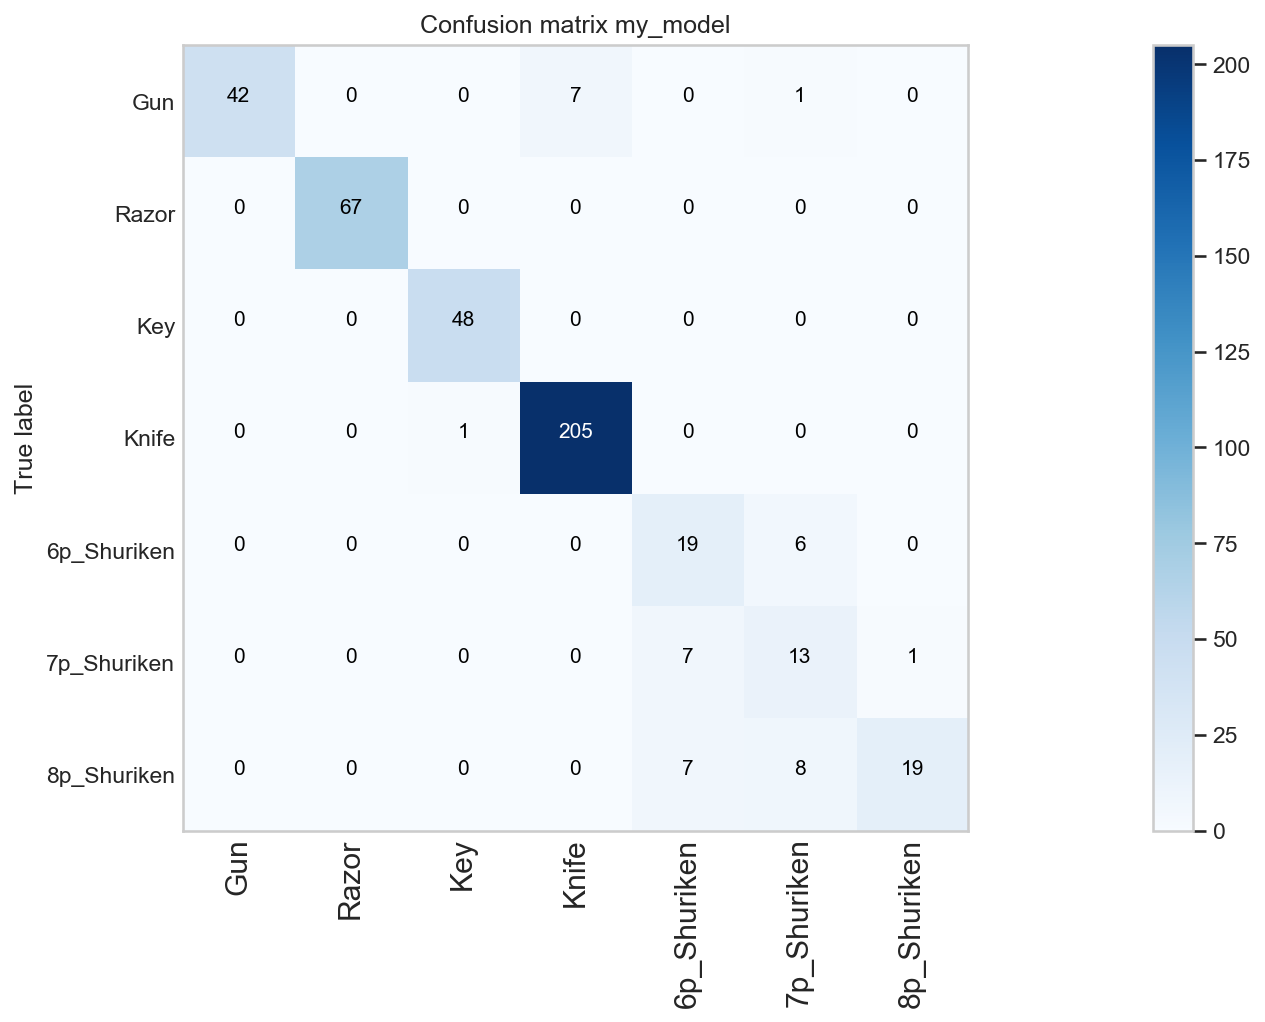

In [56]:
show_confusion_matrix(my_model, X_test, y_test)

First model predicted 7 guns as knives and 1 gun was classified as shuriken. Also one knife was classified as key. The most problematic classes are Shurkiens with diffrent amount of points. Almost half of eight point shurkiens has been misclassified as six or seven point shurkien. 

#### 6.3 Visualization of correct predicted classes
Function to visualize correct predicted classes

In [45]:
def correct_predicted_classes(trained_model, test_input, test_output):
    Y_pred = trained_model.predict(test_input)
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(test_output,axis = 1) 
    correct = []
    for i in range(len(test_output)):
        if(Y_pred_classes[i] == Y_true[i]):
            correct.append(i)
        if(len(correct) == 4):
            break
    fig, ax = plt.subplots(2,2, figsize=(12,6))
    fig.set_size_inches(10,10)
    ax[0,0].imshow(test_input[correct[0]].squeeze(), cmap='gray')
    ax[0,0].set_title("Predicted Label : " + str(classes[Y_pred_classes[correct[0]]]) + "\n"+"Actual Label : " + 
                     str(classes[Y_true[correct[0]]]))
    ax[0,1].imshow(test_input[correct[1]].squeeze(), cmap='gray')
    ax[0,1].set_title("Predicted Label : " + str(classes[Y_pred_classes[correct[1]]]) + "\n"+"Actual Label : " + 
                     str(classes[Y_true[correct[1]]]))
    ax[1,0].imshow(test_input[correct[2]].squeeze(), cmap='gray')
    ax[1,0].set_title("Predicted Label : " + str(classes[Y_pred_classes[correct[2]]]) + "\n"+"Actual Label : " + 
                     str(classes[Y_true[correct[2]]]))
    ax[1,1].imshow(test_input[correct[3]].squeeze(), cmap='gray')
    ax[1,1].set_title("Predicted Label : " + str(classes[Y_pred_classes[correct[3]]]) + "\n"+"Actual Label : " + 
                     str(classes[Y_true[correct[3]]]))

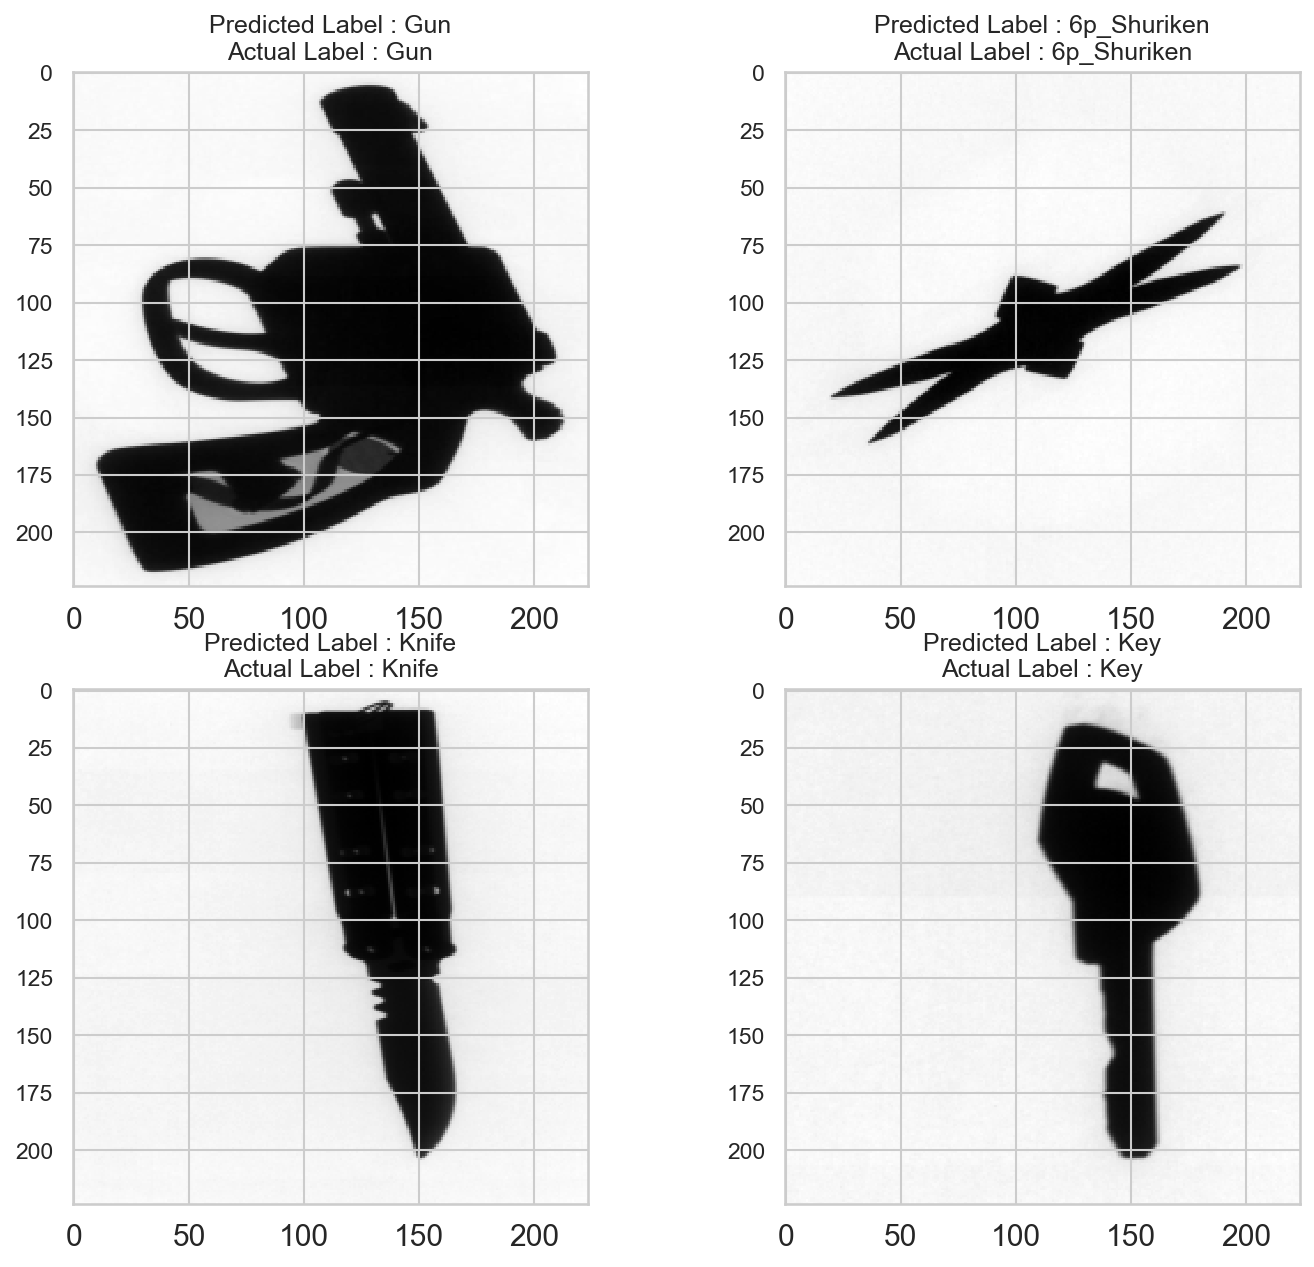

In [46]:
correct_predicted_classes(my_model, X_test, y_test)

#### 6.4 Visualization of incorrect predicted classes
Function to visualize incorrect predicted classes

In [52]:
def incorrect_predicted_classes(trained_model, test_input, test_output):
    Y_pred = trained_model.predict(test_input)
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(test_output,axis = 1) 
    incorrect = []
    for i in range(len(test_output)):
        if(not Y_pred_classes[i] == Y_true[i]):
            incorrect.append(i)
        if(len(incorrect) == 4):
            break
    fig, ax = plt.subplots(2,2, figsize=(12,6))
    fig.set_size_inches(10,10)
    ax[0,0].imshow(test_input[incorrect[0]].squeeze(), cmap='gray')
    ax[0,0].set_title("Predicted Label : " + str(classes[Y_pred_classes[incorrect[0]]]) + "\n"+"Actual Label : " + 
                     str(classes[Y_true[incorrect[0]]]))
    ax[0,1].imshow(test_input[incorrect[1]].squeeze(), cmap='gray')
    ax[0,1].set_title("Predicted Label : " + str(classes[Y_pred_classes[incorrect[1]]]) + "\n"+"Actual Label : " + 
                     str(classes[Y_true[incorrect[1]]]))
    ax[1,0].imshow(test_input[incorrect[2]].squeeze(), cmap='gray')
    ax[1,0].set_title("Predicted Label : " + str(classes[Y_pred_classes[incorrect[2]]]) + "\n"+"Actual Label : " + 
                     str(classes[Y_true[incorrect[2]]]))
    ax[1,1].imshow(test_input[incorrect[3]].squeeze(), cmap='gray')
    ax[1,1].set_title("Predicted Label : " + str(classes[Y_pred_classes[incorrect[3]]]) + "\n"+"Actual Label : " + 
                     str(classes[Y_true[incorrect[3]]]))

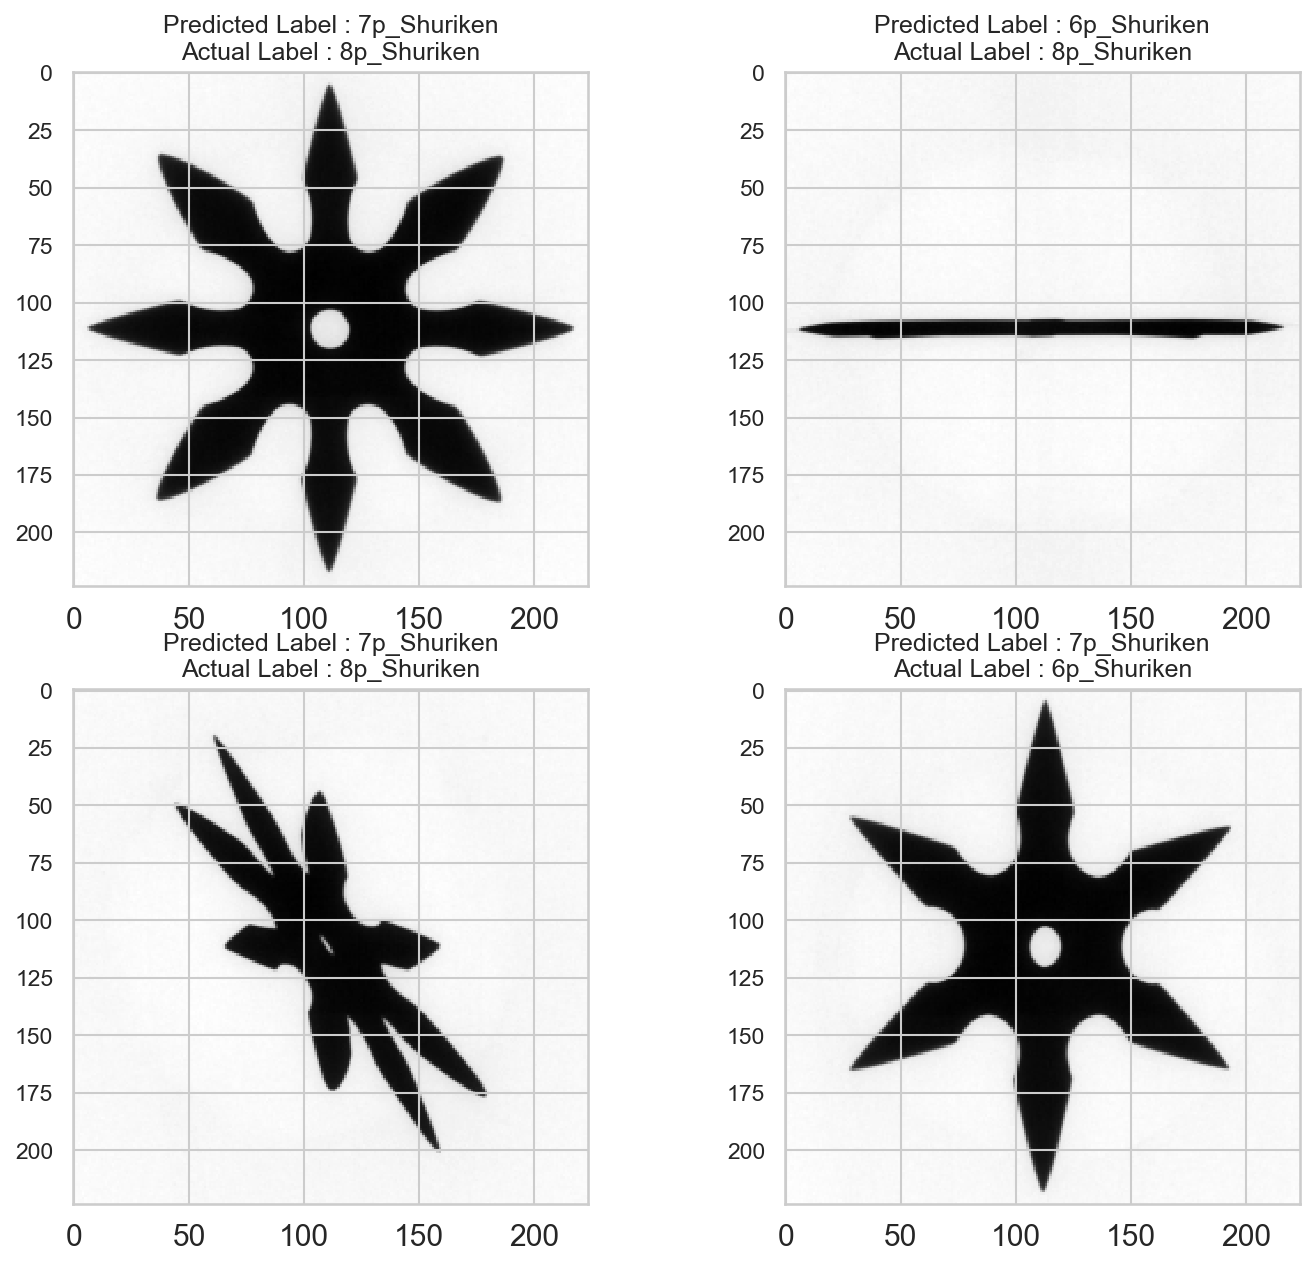

In [53]:
incorrect_predicted_classes(my_model, X_test, y_test)

The most problematic classes are shurkiens for model to predict. Though Gun might be also difficult to classify for model as the confusion matrix above shows. Rest of classes seems to be easy to predicted for own-builded model.

#### 6.5 Classification report
Function to print classification report 

In [57]:
def print_classification_report(trained_model, test_input, test_output):
    Y_pred = trained_model.predict(test_input)
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(test_output, axis = 1) 
    items = classes.values()
    print(classification_report(Y_true, Y_pred_classes, target_names = items))

In [58]:
print_classification_report(my_model, X_test, y_test)

              precision    recall  f1-score   support

         Gun       1.00      0.84      0.91        50
       Razor       1.00      1.00      1.00        67
         Key       0.98      1.00      0.99        48
       Knife       0.97      1.00      0.98       206
 6p_Shuriken       0.58      0.76      0.66        25
 7p_Shuriken       0.46      0.62      0.53        21
 8p_Shuriken       0.95      0.56      0.70        34

    accuracy                           0.92       451
   macro avg       0.85      0.82      0.82       451
weighted avg       0.93      0.92      0.92       451



### 7. MobileNetV2 Model
For the comparison and probably better perfomance, MobileNetV2 and ResNetV2 models were used for this project with transfer learning

#### 7.1 Trasnfer to RGB color space
Both models requires 3 channels images, so I need to back transfer images to rgb color space.

In [26]:

def rgb_img_transfer(input_list):
    transfered_img = []
    for i in tqdm(range(len(input_list))):
        transfered_img.append(cv2.cvtColor(input_list[i], cv2.COLOR_GRAY2RGB))
        
    transfered_img = np.asarray(transfered_img)
    return transfered_img

In [27]:
Xrgb_train = rgb_img_transfer(X_train)

100%|██████████| 1696/1696 [00:00<00:00, 2860.44it/s]


In [28]:
Xrgb_test = rgb_img_transfer(X_test)

100%|██████████| 451/451 [00:00<00:00, 3338.09it/s]


In [50]:
Xrgb_test.shape

(451, 224, 224, 3)

#### 7.2 Transfer model MobileNetV2
transfer_model function for future transfer modeling, if it is required for more then one model to transfer model.

In [52]:
def transfer_model(base_model):
    
    input_model = base_model(weights='imagenet', include_top=False, input_shape=(h,w,3))
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=input_model.output_shape[1:]))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(128, activation='relu'))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(0.5))
    top_model.add(Dense(7, activation='softmax'))
    
    new_model = Sequential()
    new_model.add(input_model)
    new_model.add(top_model)
    new_model.layers[0].trainable = False
    reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
    new_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    new_model.summary()
    return new_model

In [53]:
MobileNetV2_model = transfer_model(MobileNetV2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
sequential_1 (Sequential)    (None, 7)                 8029703   
Total params: 10,287,687
Trainable params: 8,029,447
Non-trainable params: 2,258,240
_________________________________________________________________


In [55]:
MobileNetV2_checkpoint = get_checkpoint('MobileNetV2')

#### 7.3 Data augmentation and model fit
Input train data that has 3-channels colors has to be augmented again.

In [57]:
datagen.fit(Xrgb_train)

In [58]:
MobileNetV2_history = MobileNetV2_model.fit(datagen.flow(Xrgb_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (Xrgb_test, y_test), verbose=1, 
                              steps_per_epoch=Xrgb_train.shape[0] // batch_size,
                              callbacks = [reduce_lr, early_stopping, MobileNetV2_checkpoint])

Epoch 1/100
53/53 [==============================] - 78s 1s/step - loss: 0.6655 - accuracy: 0.7913 - val_loss: 0.4569 - val_accuracy: 0.8869
Epoch 2/100
53/53 [==============================] - 113s 2s/step - loss: 0.3335 - accuracy: 0.8838 - val_loss: 0.2102 - val_accuracy: 0.9091
Epoch 3/100
53/53 [==============================] - 74s 1s/step - loss: 0.2477 - accuracy: 0.9110 - val_loss: 0.1603 - val_accuracy: 0.9246
Epoch 4/100
53/53 [==============================] - 86s 2s/step - loss: 0.2286 - accuracy: 0.9145 - val_loss: 0.1042 - val_accuracy: 0.9534
Epoch 5/100
53/53 [==============================] - 80s 2s/step - loss: 0.2177 - accuracy: 0.9198 - val_loss: 0.0965 - val_accuracy: 0.9579
Epoch 6/100
53/53 [==============================] - 85s 2s/step - loss: 0.1858 - accuracy: 0.9292 - val_loss: 0.0836 - val_accuracy: 0.9645
Epoch 7/100
53/53 [==============================] - 98s 2s/step - loss: 0.1782 - accuracy: 0.9322 - val_loss: 0.1013 - val_accuracy: 0.9512
Epoch 8/100


Epoch 59/100
53/53 [==============================] - 71s 1s/step - loss: 0.1075 - accuracy: 0.9528 - val_loss: 0.0536 - val_accuracy: 0.9756
Epoch 60/100
53/53 [==============================] - 67s 1s/step - loss: 0.1051 - accuracy: 0.9552 - val_loss: 0.0537 - val_accuracy: 0.9778
Epoch 61/100
53/53 [==============================] - 61s 1s/step - loss: 0.1121 - accuracy: 0.9499 - val_loss: 0.0536 - val_accuracy: 0.9778
Epoch 62/100
53/53 [==============================] - 78s 1s/step - loss: 0.1025 - accuracy: 0.9599 - val_loss: 0.0534 - val_accuracy: 0.9756
Epoch 63/100
53/53 [==============================] - 75s 1s/step - loss: 0.1121 - accuracy: 0.9528 - val_loss: 0.0534 - val_accuracy: 0.9778
Epoch 64/100
53/53 [==============================] - 78s 1s/step - loss: 0.1075 - accuracy: 0.9575 - val_loss: 0.0533 - val_accuracy: 0.9778
Epoch 65/100
53/53 [==============================] - 81s 2s/step - loss: 0.1093 - accuracy: 0.9570 - val_loss: 0.0534 - val_accuracy: 0.9778
Epoch 

In [79]:
dump(MobileNetV2_history.history, 
     open('/Users/mateuszkucharuk/Desktop/0_forbidden_items_detector/Projekt_v3__data/MobileNetV2_history.pkl', 'wb'))

#### 7.4 MobileNetv2 evaluation

In [60]:
score = MobileNetV2_model.evaluate(Xrgb_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

15/15 [==============================] - 11s 722ms/step - loss: 0.0903 - accuracy: 0.9623
Loss: 0.0903
Accuracy: 0.9623


#### 7.5 MobileNetV2 train and validation curves, confusion matrix and correct/incorrect predicted classes

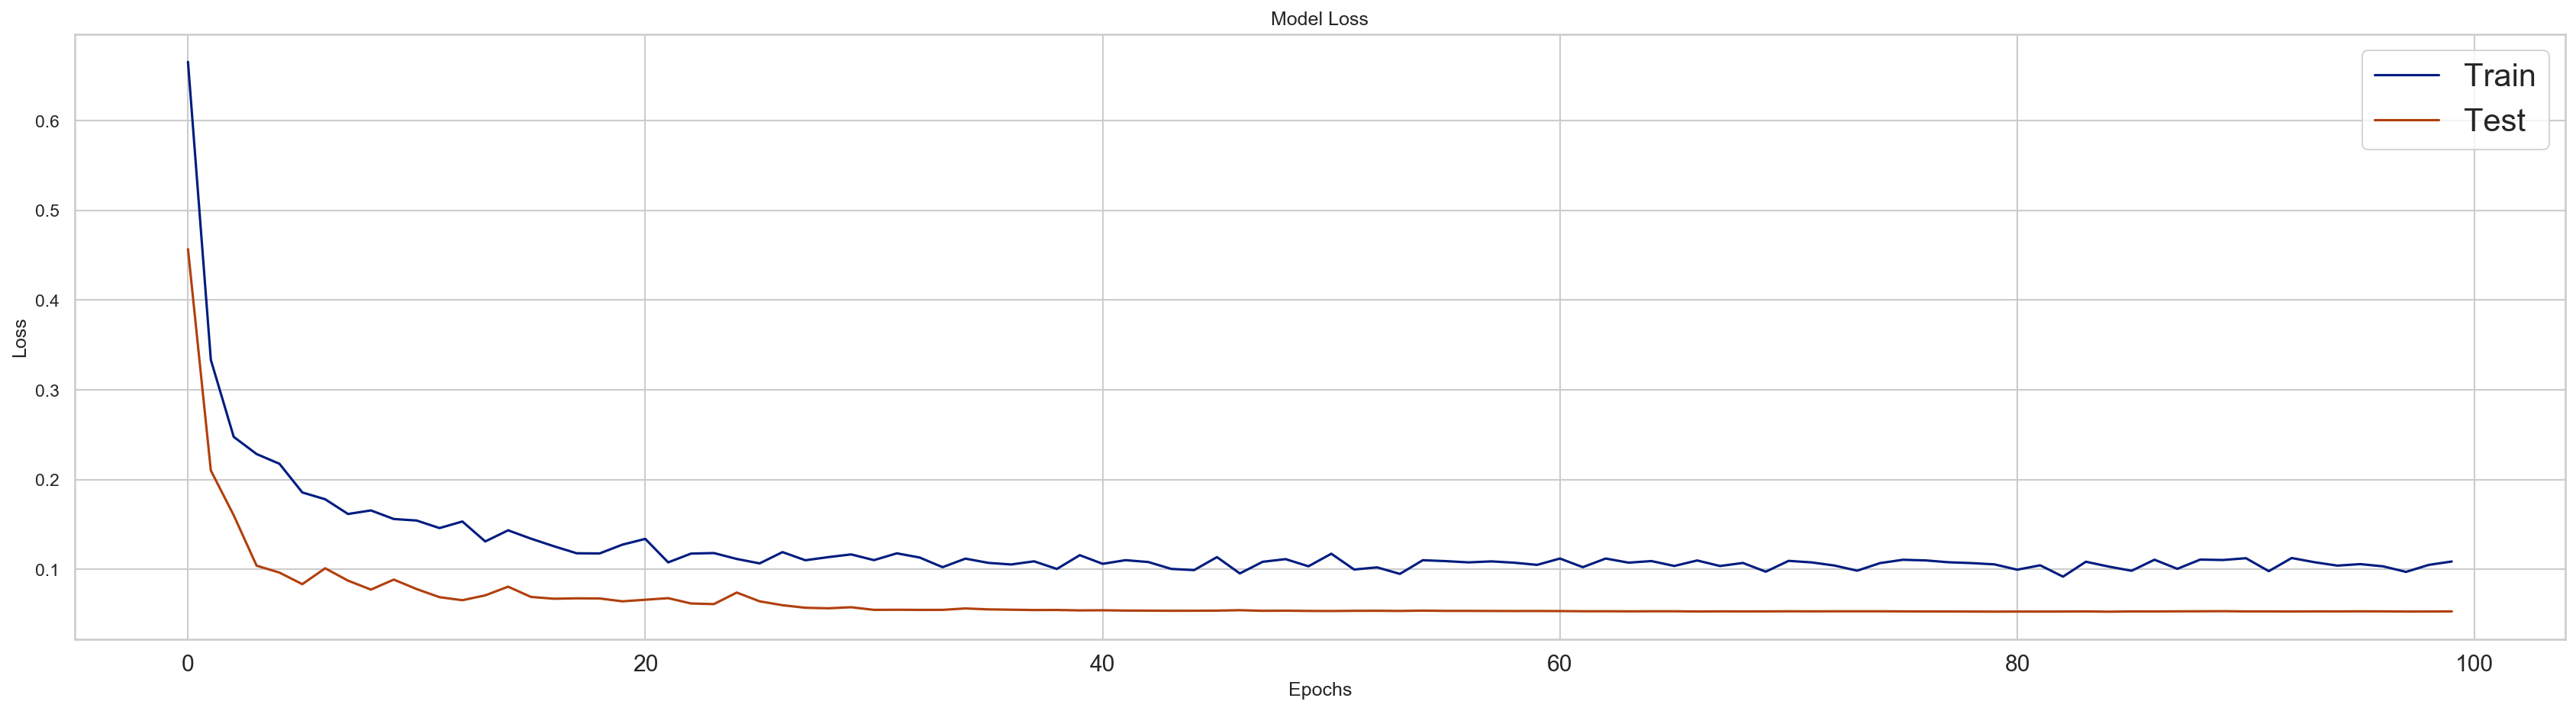

In [81]:
plt.plot(MobileNetV2_history.history['loss'])
plt.plot(MobileNetV2_history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

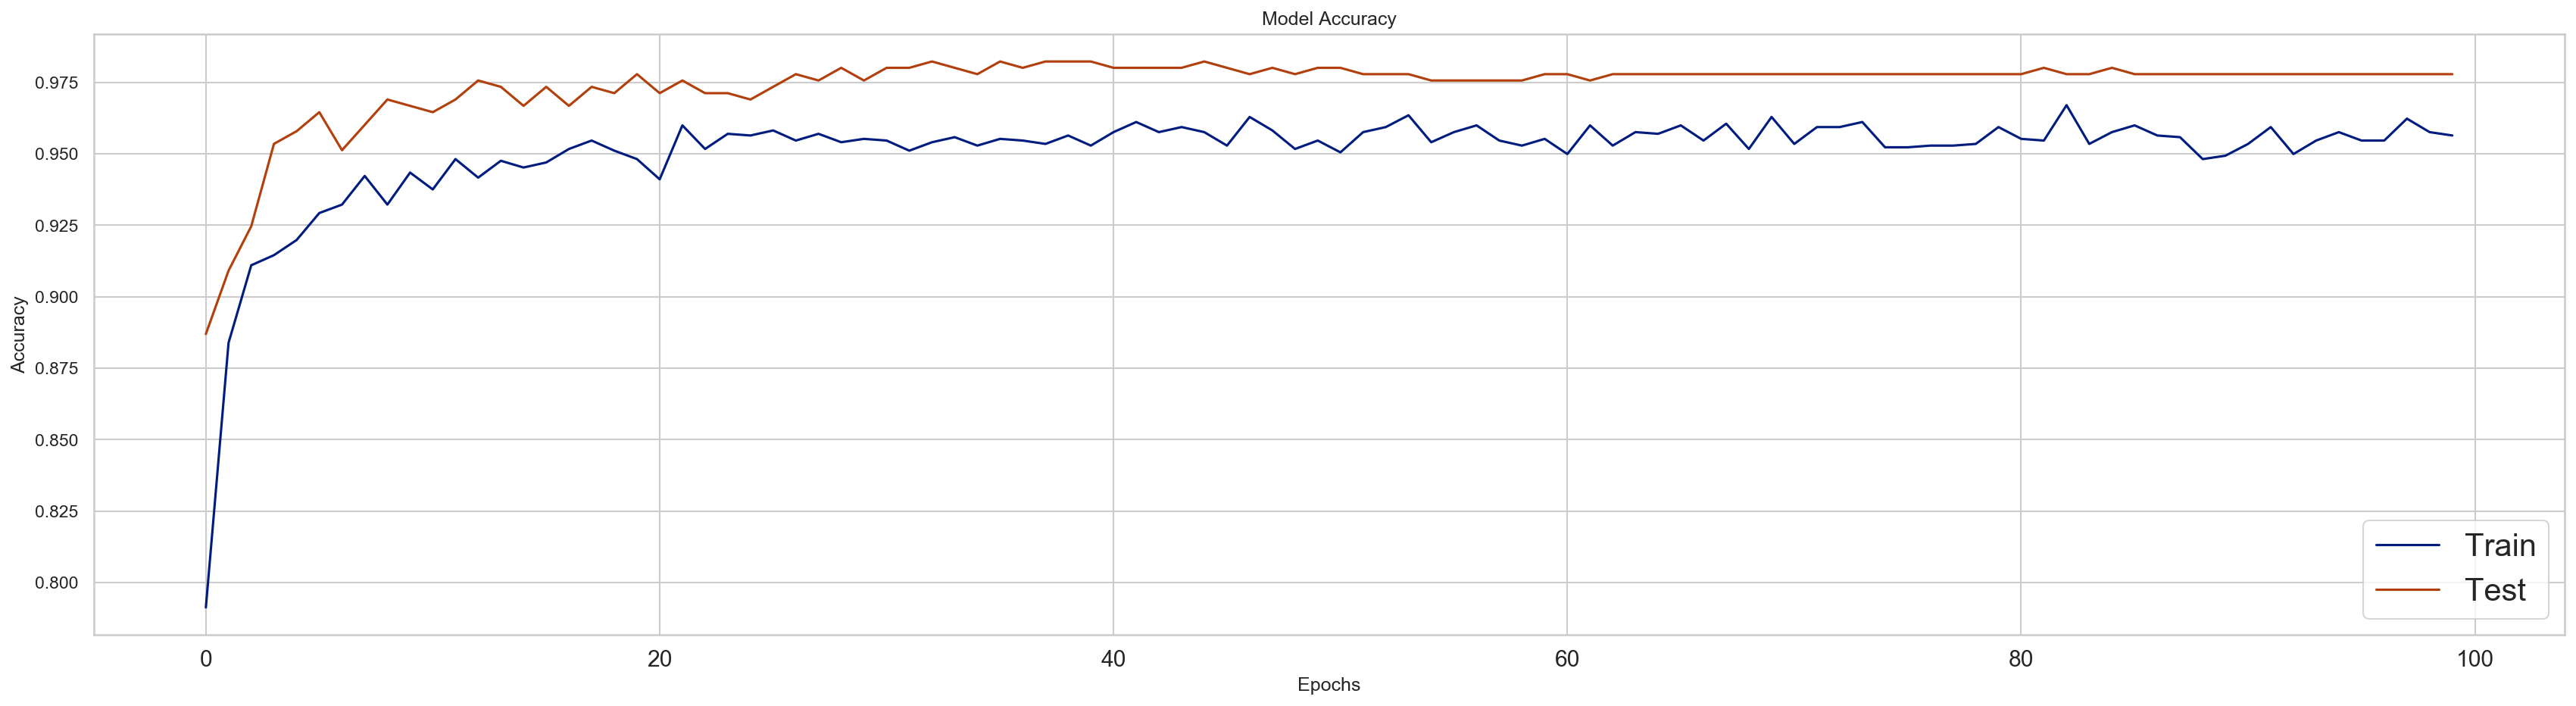

In [82]:
plt.plot(MobileNetV2_history.history['accuracy'])
plt.plot(MobileNetV2_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

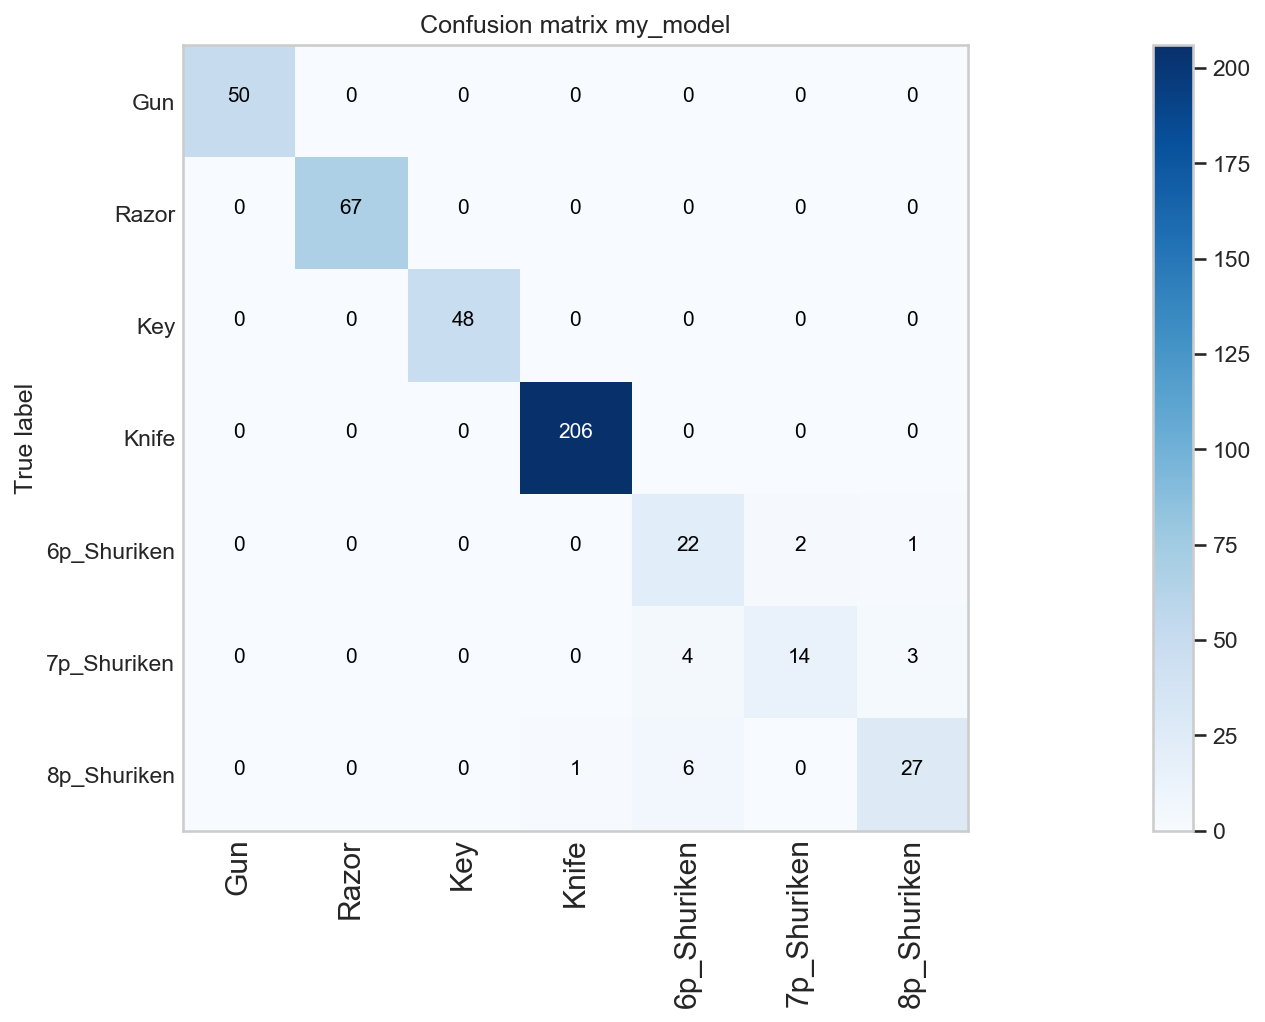

In [59]:
show_confusion_matrix(MobileNetV2_model, Xrgb_test, y_test)

Most of the major classes got correctly classified. Besides model has problem with classification of shurkiens, though most of them has been classified correctly.

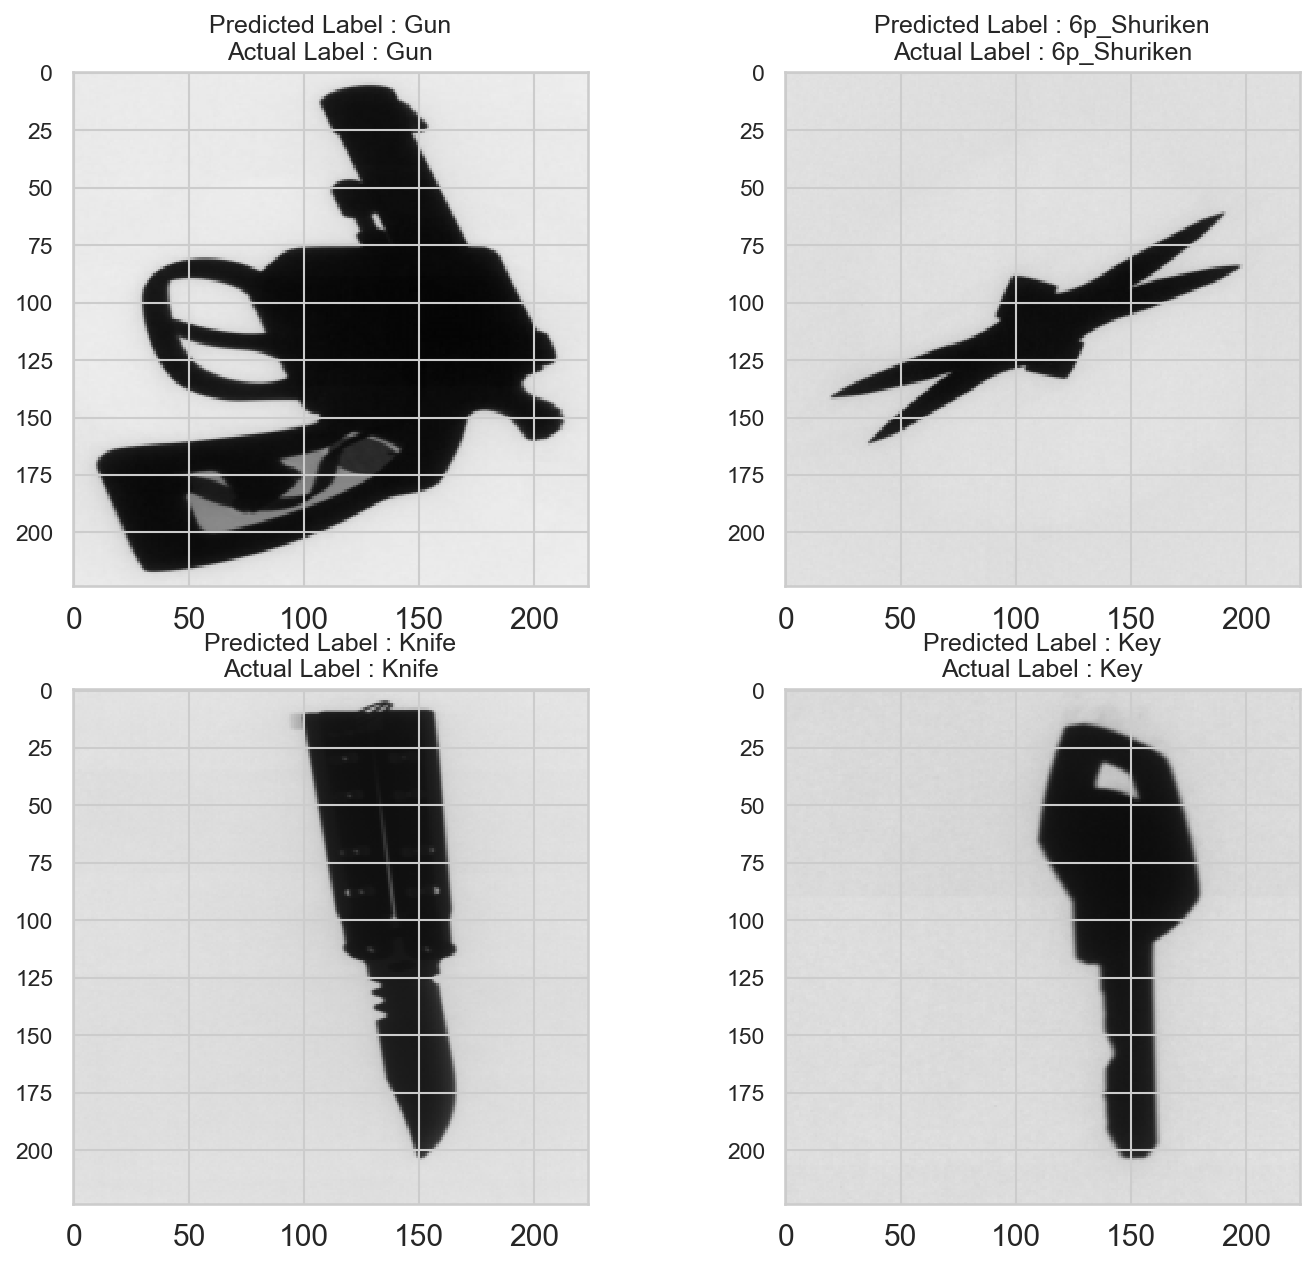

In [64]:
correct_predicted_classes(MobileNetV2_model, Xrgb_test, y_test)

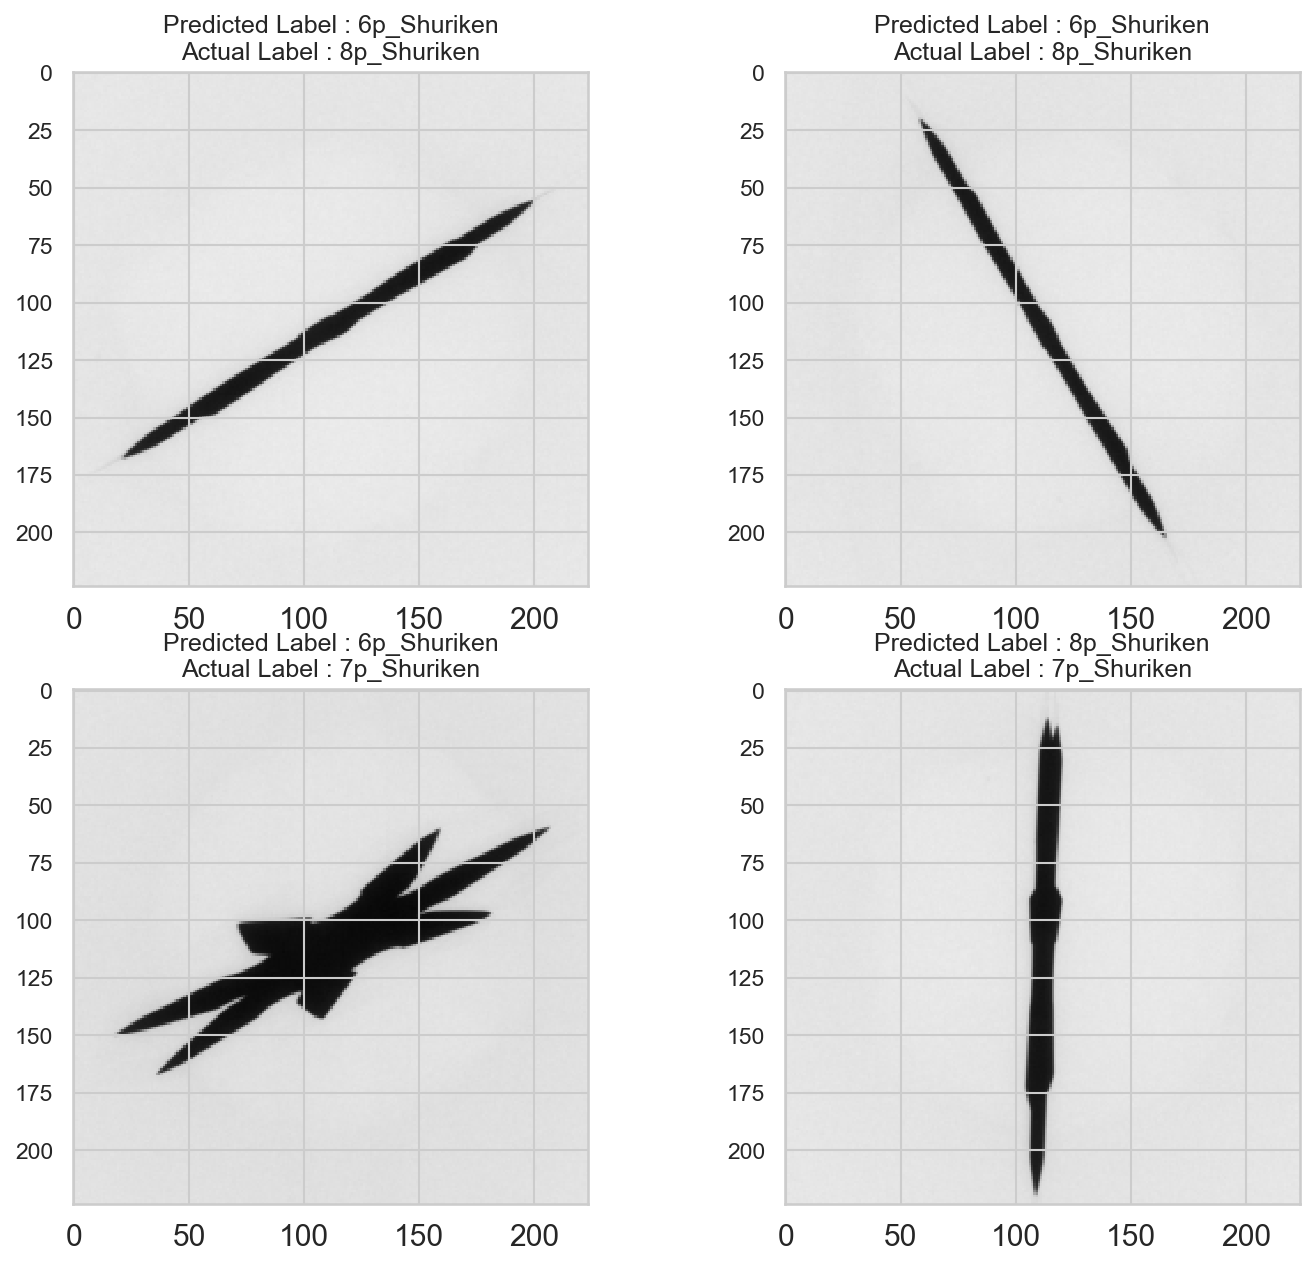

In [61]:
incorrect_predicted_classes(MobileNetV2_model, Xrgb_test, y_test)

It looks like model has no problems with predicting classes. Only shurikends with diffrent amount of points and even human couldnt recognize how many points these have. It is caused by their placemnt on the image.

#### 7.6 Classification report for MobileNetV2

In [62]:
print_classification_report(MobileNetV2_model, Xrgb_test, y_test)

              precision    recall  f1-score   support

         Gun       1.00      1.00      1.00        50
       Razor       1.00      1.00      1.00        67
         Key       1.00      1.00      1.00        48
       Knife       1.00      1.00      1.00       206
 6p_Shuriken       0.69      0.88      0.77        25
 7p_Shuriken       0.88      0.67      0.76        21
 8p_Shuriken       0.87      0.79      0.83        34

    accuracy                           0.96       451
   macro avg       0.92      0.91      0.91       451
weighted avg       0.96      0.96      0.96       451



By Looking at the Precision of the 8p_Shuriken, I can see that MobileNet model predicted only 69% of 6p_Shuriken correctly out of the total images it predicted as 6p_Shuriken.

### 8. ResNetV2 model

#### 8.1 Transfer model ResNetV2

In [ ]:
ResNet50V2_model = transfer_model(ResNet50V2)

In [ ]:
ResNet50V2_checkpoint = get_checkpoint('ResNetV2')

#### 8.2 ResNetV2 model fit

In [102]:

ResNetV2_history = ResNet50V2_model.fit(datagen.flow(Xrgb_train, y_train, batch_size = batch_size), epochs = epochs, 
                              validation_data = (Xrgb_test, y_test), verbose=1, 
                              steps_per_epoch=Xrgb_train.shape[0] // batch_size,
                              callbacks = [reduce_lr, early_stopping, ResNet50V2_checkpoint])

Epoch 1/100
53/53 [==============================] - 165s 3s/step - loss: 0.5798 - accuracy: 0.8149 - val_loss: 0.1486 - val_accuracy: 0.9468
Epoch 2/100
53/53 [==============================] - 167s 3s/step - loss: 0.2855 - accuracy: 0.8909 - val_loss: 0.1285 - val_accuracy: 0.9490
Epoch 3/100
53/53 [==============================] - 164s 3s/step - loss: 0.2459 - accuracy: 0.9021 - val_loss: 0.1611 - val_accuracy: 0.9290
Epoch 4/100
53/53 [==============================] - 166s 3s/step - loss: 0.2329 - accuracy: 0.9104 - val_loss: 0.1073 - val_accuracy: 0.9557
Epoch 5/100
53/53 [==============================] - 163s 3s/step - loss: 0.1968 - accuracy: 0.9292 - val_loss: 0.0991 - val_accuracy: 0.9534
Epoch 6/100
53/53 [==============================] - 166s 3s/step - loss: 0.2020 - accuracy: 0.9245 - val_loss: 0.0950 - val_accuracy: 0.9557
Epoch 7/100
53/53 [==============================] - 167s 3s/step - loss: 0.1949 - accuracy: 0.9298 - val_loss: 0.0926 - val_accuracy: 0.9623
Epoch 

In [103]:
dump(ResNetV2_history.history, 
     open('/Users/mateuszkucharuk/Desktop/0_forbidden_items_detector/Projekt_v3__data/ResNetV2_history.pkl', 'wb'))

#### 8.3 ResnetV2 model evalution

In [63]:
score = ResNet50V2_model.evaluate(Xrgb_test, y_test)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

15/15 [==============================] - 32s 2s/step - loss: 0.0785 - accuracy: 0.9690
Loss: 0.0785
Accuracy: 0.9690


#### 8.4 ResNetV2 train and validation curves, confusion matrix and correct/incorrect predicted classes

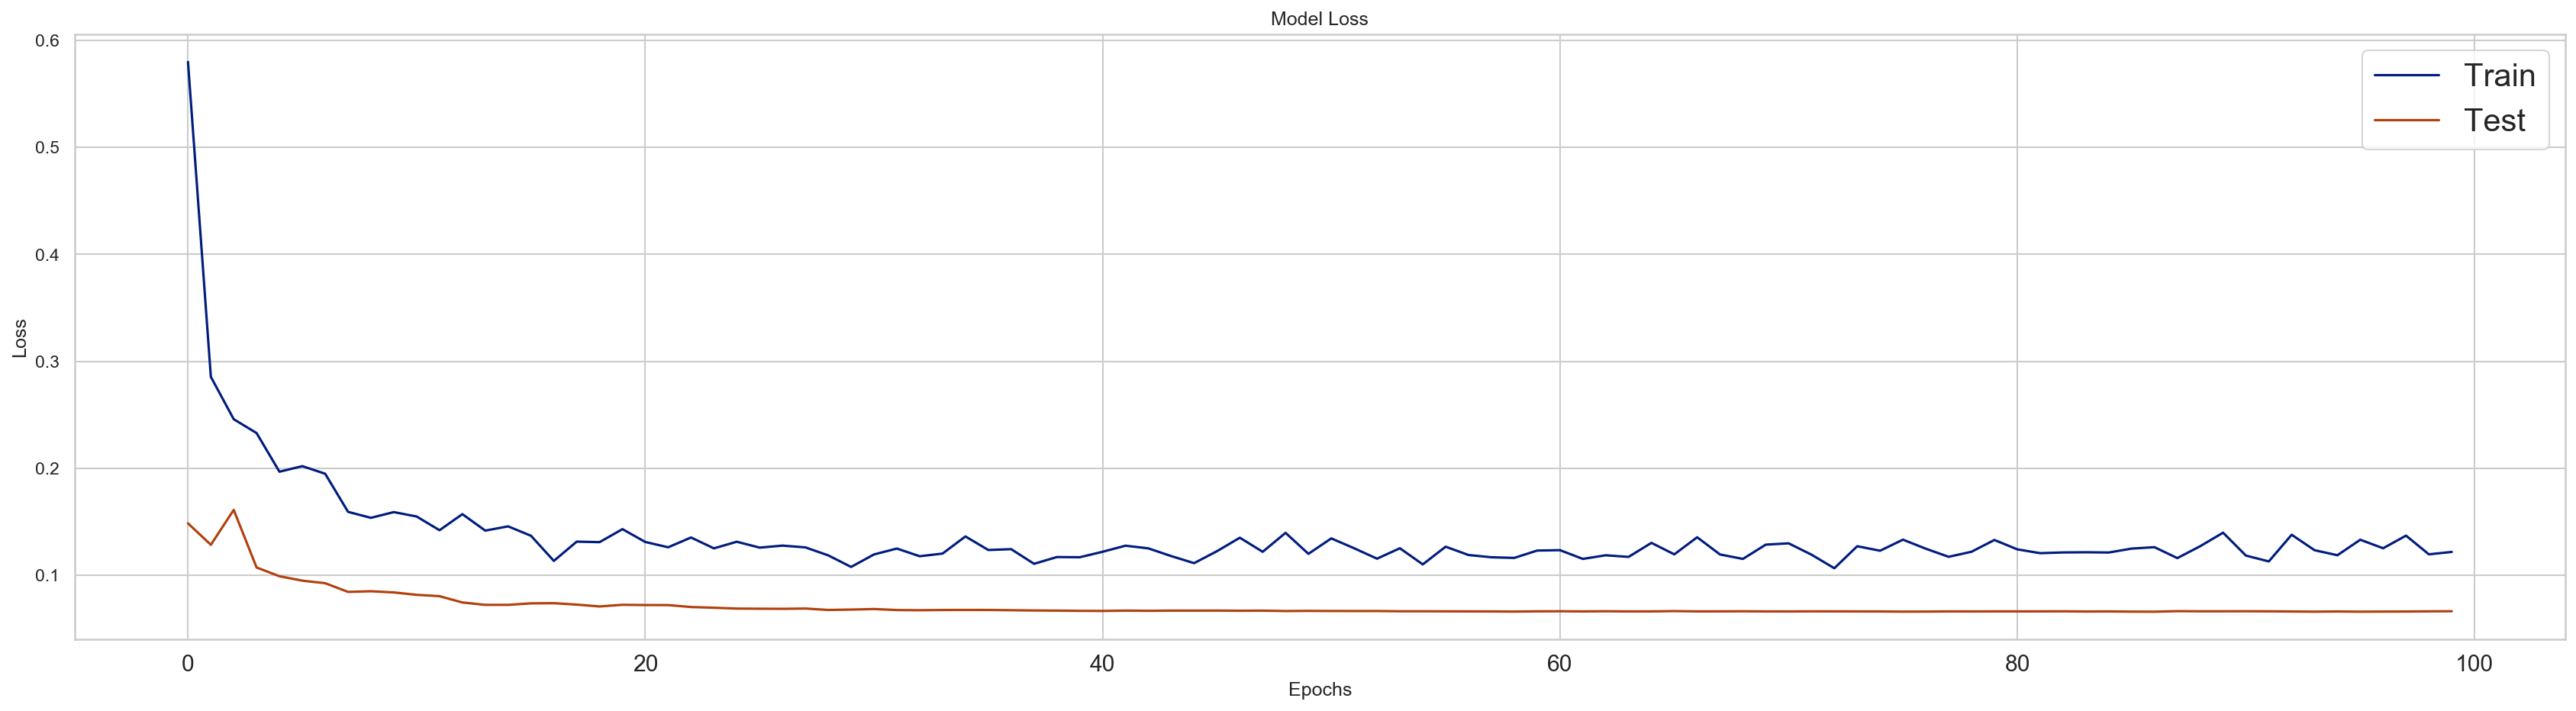

In [105]:
plt.plot(ResNetV2_history.history['loss'])
plt.plot(ResNetV2_history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

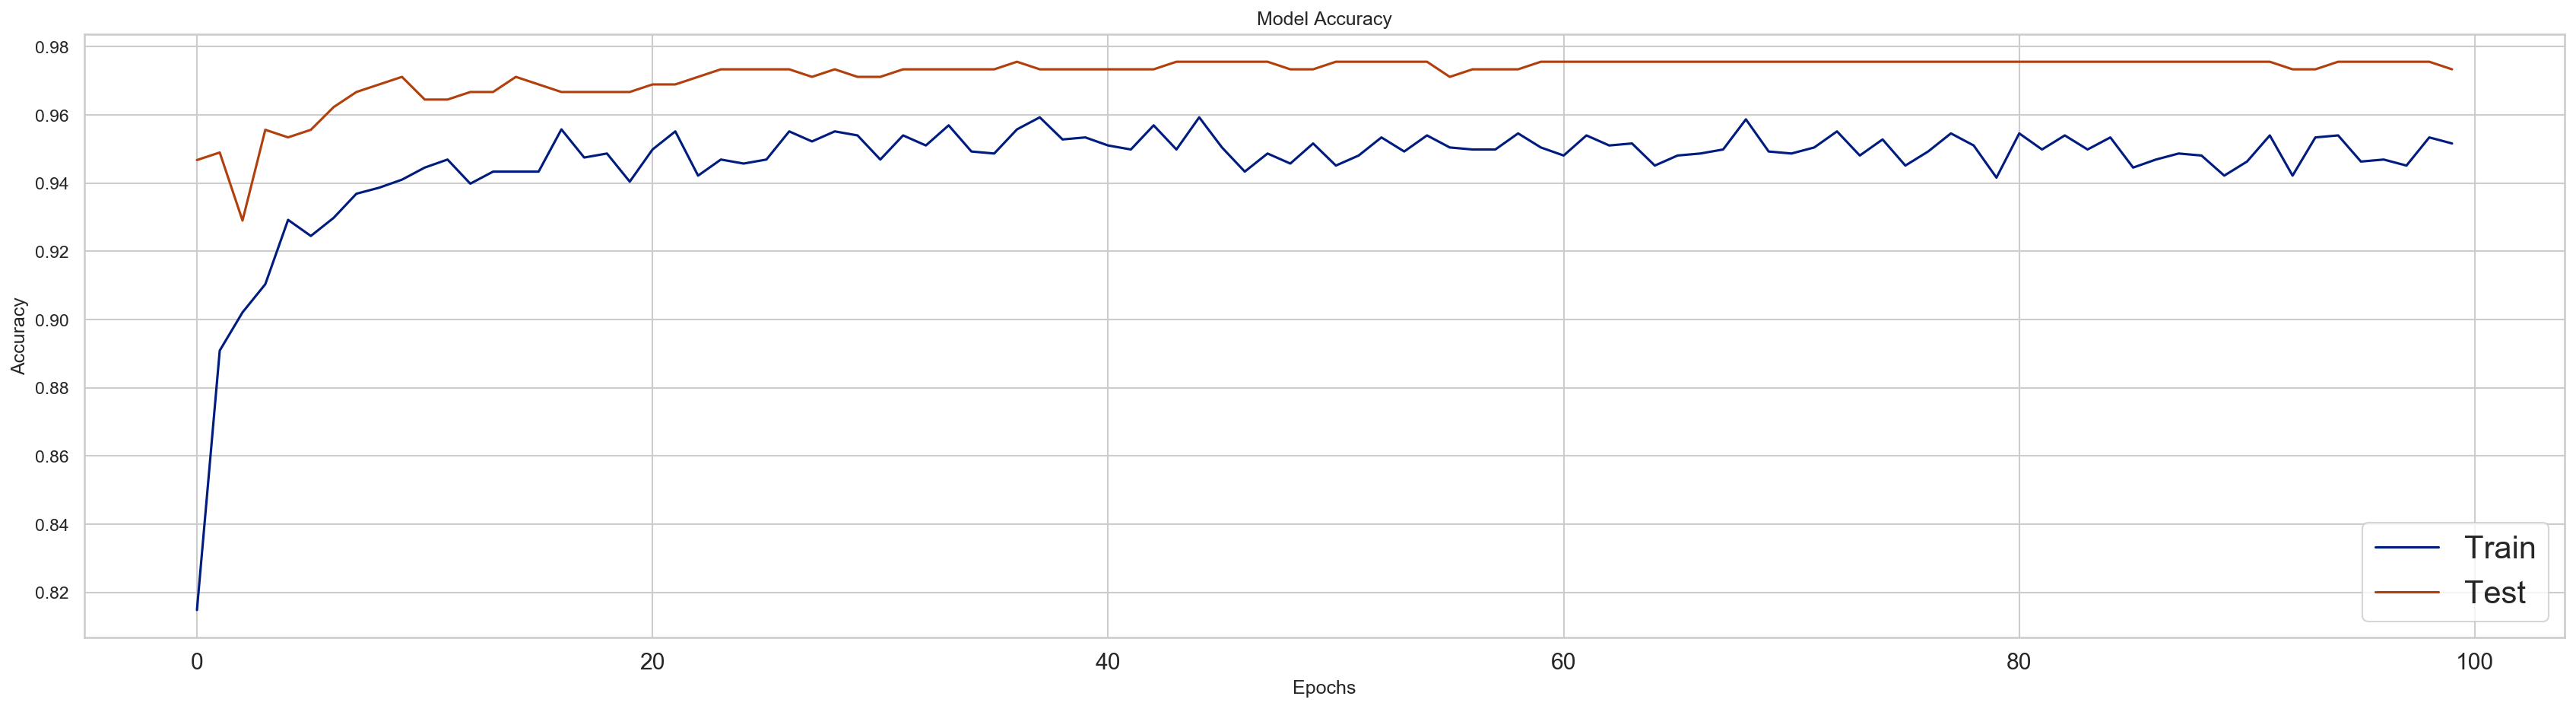

In [106]:
plt.plot(ResNetV2_history.history['accuracy'])
plt.plot(ResNetV2_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

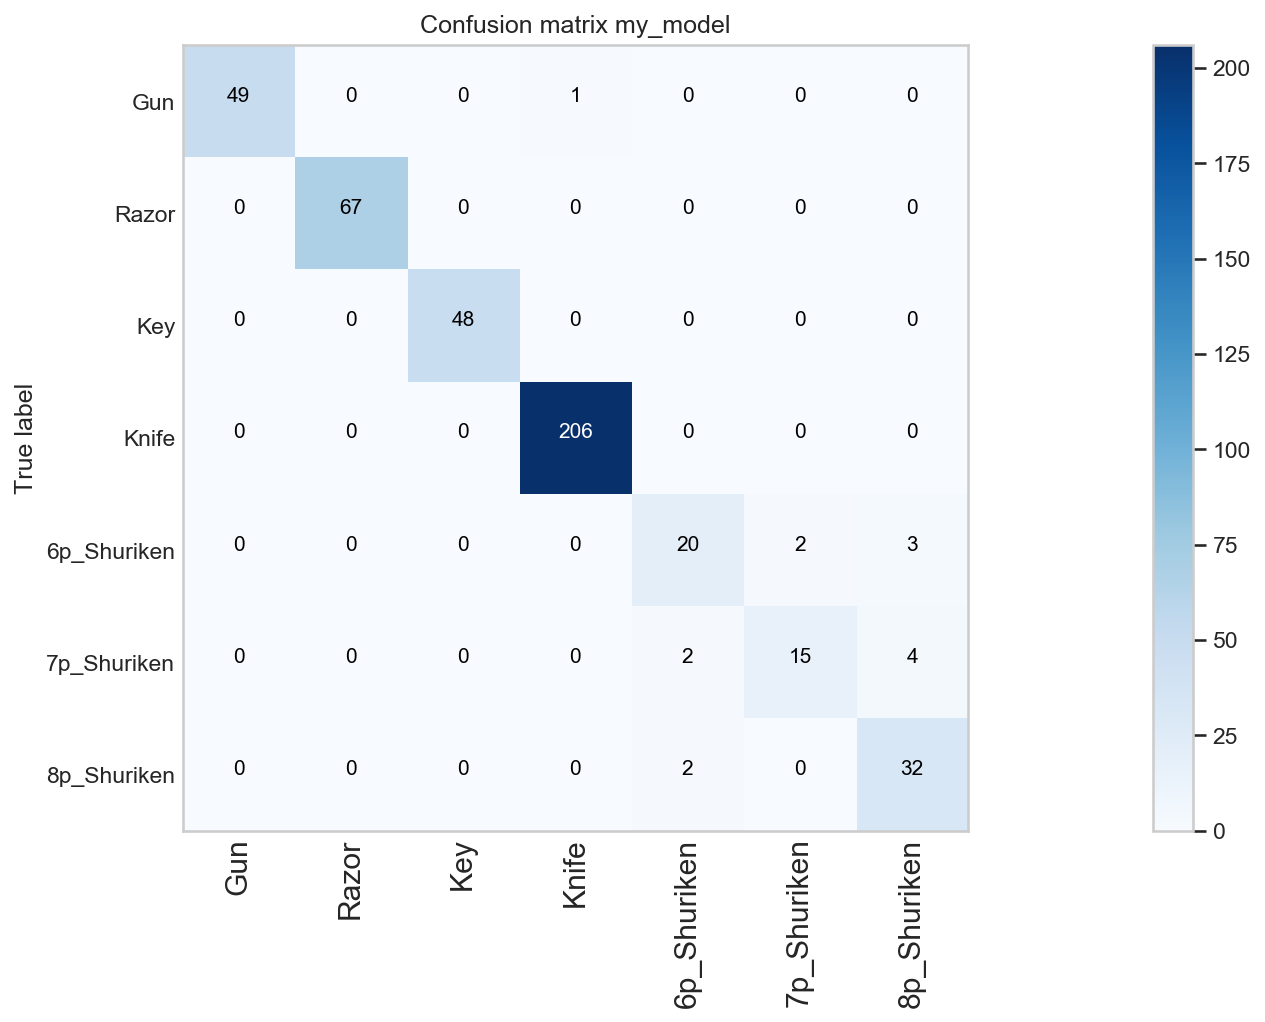

In [65]:
show_confusion_matrix(ResNet50V2_model, Xrgb_test, y_test)

Only one guns got misclassified as Knife. 5 of six point shurkiens was misclassified. 6 of seven point shurkien got misclassified and 2 of Eight point shurkiens was misclassified.

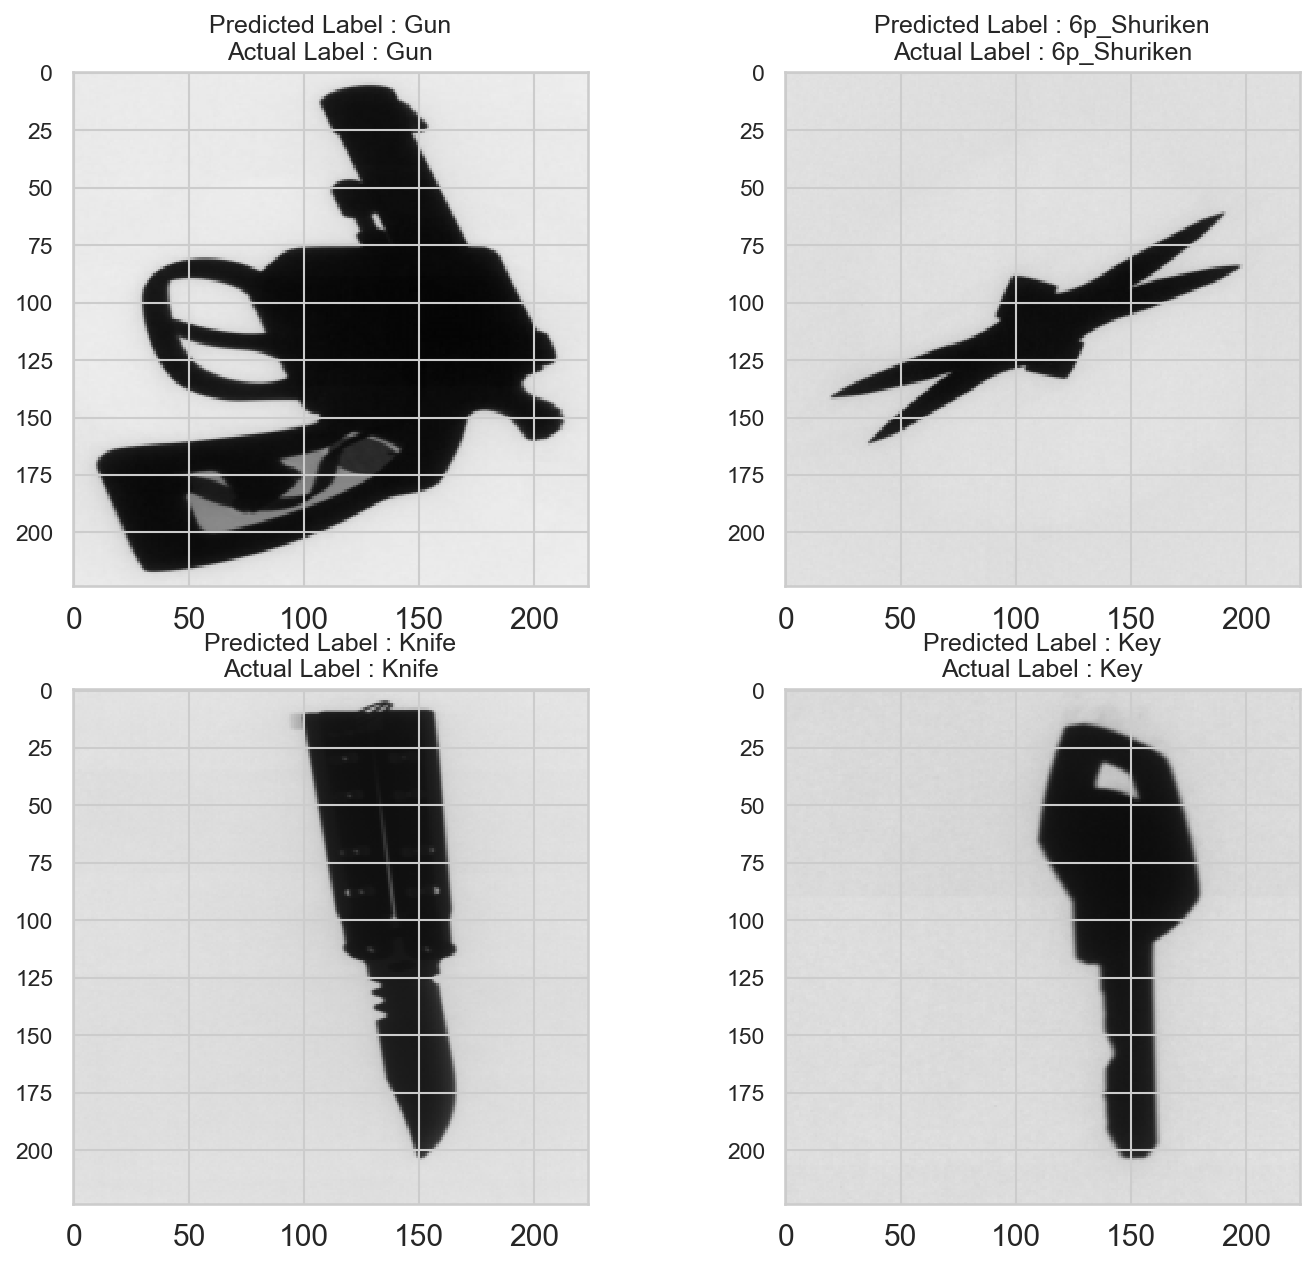

In [66]:
correct_predicted_classes(ResNet50V2_model, Xrgb_test, y_test)

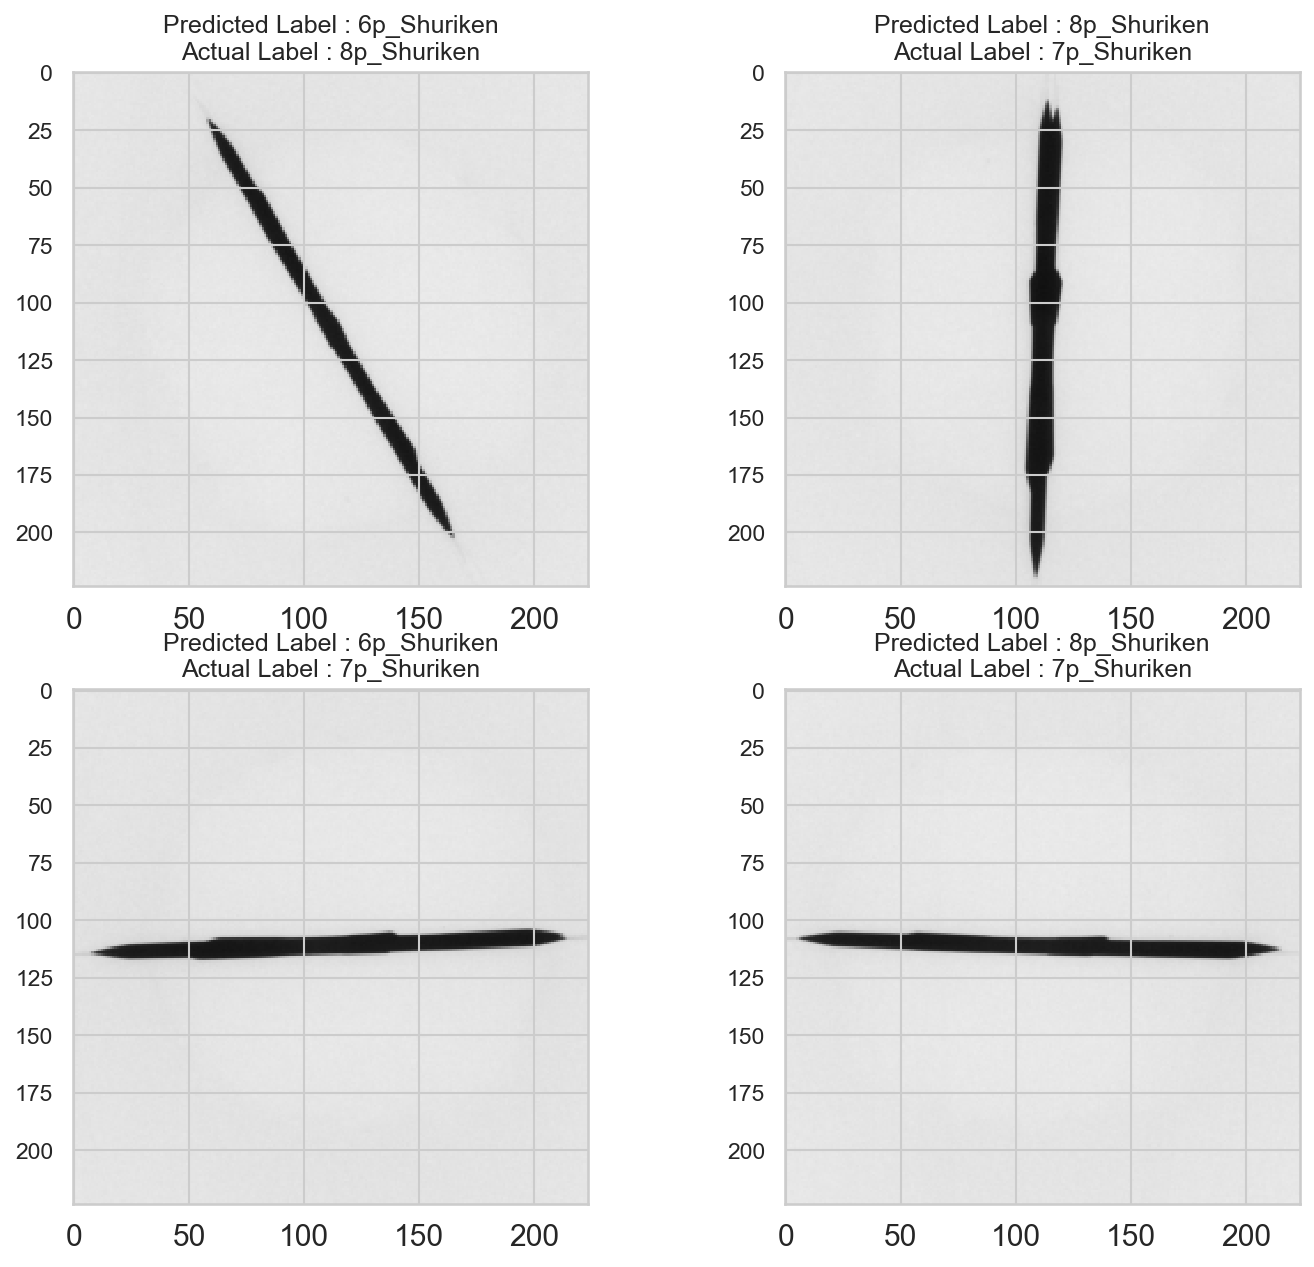

In [67]:
incorrect_predicted_classes(ResNet50V2_model, Xrgb_test, y_test)

#### 8.5 Classification report for ResNetV2

In [68]:
print_classification_report(ResNet50V2_model, Xrgb_test, y_test)

              precision    recall  f1-score   support

         Gun       1.00      0.98      0.99        50
       Razor       1.00      1.00      1.00        67
         Key       1.00      1.00      1.00        48
       Knife       1.00      1.00      1.00       206
 6p_Shuriken       0.83      0.80      0.82        25
 7p_Shuriken       0.88      0.71      0.79        21
 8p_Shuriken       0.82      0.94      0.88        34

    accuracy                           0.97       451
   macro avg       0.93      0.92      0.92       451
weighted avg       0.97      0.97      0.97       451



Looks like ResNet50 model has better performance by 1% for accuaracy then MobilNet. It is not much diffrence though. It is also noteable that MobileNet succesfully classified all of the major classes(Gun, Razor, Key and Knife) and had much trouble with shurikens. On the other hand ResNet misclassified only one gun but have better precision with shurikens then MobileNet.

### 9. Summary

The goal of the project was to predict class based on image. Based on own-builded model with accuaracy almost 92%, MobileNet 96% and ResNet model 97% the goal was achived. Main diffrence between own-builded model it is that has less accuaracy but it is learnining process takes less time. ResNet and MobileNet models performed slower but has better accuaracy. MobileNet classified correctly all of the guns, razors, knives, keys but had problems with shurkiens. On the other hand ResNet model had missclassified only one gun but has better performance with classifing shurkiens. Class shurikens was the most problematic because of its placement. With incorrec_predict_classes function it is visible that model could have problems. In some cases even humans couldnt tell how many points particular shurkien has.
GDXray database contains various images to work on with machine learning or CNN algorithms. In the future perspective it can be helpful to build a forbidden item detector in baggages. For instance instead of classifing images the algorithm could search for such items in images of baggage that contains forbidden items, this database contains baggage images.